<div class="alert block alert-info alert">

# <center> Data Science Project
# <center> A German clothing retailer seeks international Expansion

# <center> August 16.2025

#### Sources
1. Pandas Library Documentation, https://pandas.pydata.org/docs/user_guide/index.html#user-guide accessed on Aug 2025
2. Numpy Library Documentation, https://numpy.org/devdocs/user/index.html#user, accessed on Aug 2025.
. timeit, Measure execution time of small code snippets, https://docs.python.org/3/library/timeit.html, accessed on Aug 2025.
3. Scikit-learn Documentation, https://scikit-learn.org/stable/user_guide.html accessed on Aug 2025.
4. TensorFlow Documentation, https://www.tensorflow.org/guide accessed on Aug 2025.
5. Matplotlib Documentation, https://matplotlib.org/stable/users/index.html accessed on Aug 2025.
6. Seaborn Documentation, https://seaborn.pydata.org/tutorial.html accessed on Aug 2025.

In [5]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import re
import seaborn as sns
from datetime import datetime
import pprint
import dataframe_image as dfi

In [6]:
# Load datasets
passengers_eu_df = pd.read_csv('./passengersEU.csv', sep=',')
passengers_ww_df = pd.read_csv('./passengersWW.csv', sep=',')
airports_df = pd.read_csv('./airports.csv', sep=',')
airports_terms_of_lease_df = pd.read_csv('./airports_terms_of_lease.csv', sep=',')

print(f"European passengers dataset shape {passengers_eu_df.shape}")
print(f"Worldwide passengers dataset shape {passengers_ww_df.shape}")
print(f"Airports information dataset shape {airports_df.shape}")
print(f"Airports terms of lease dataset shape is {airports_terms_of_lease_df.shape}")

European passengers dataset shape (132234, 17)
Worldwide passengers dataset shape (73140, 16)
Airports information dataset shape (34, 5)
Airports terms of lease dataset shape is (12, 1)


# Data Exploration and Visualization

## Airports Terms of Lease Dataset

In [7]:
# Create a column for each value
airports_terms_of_lease_df[['airport', 'sqm_of_store', 'price_per_sqm_month']] = airports_terms_of_lease_df['Airport,sqm of store,price per sqm/month'].str.split(',', expand=True)

# Drop the original combined column
airports_terms_of_lease_df = airports_terms_of_lease_df.drop(airports_terms_of_lease_df.columns[0], axis=1)

display(airports_terms_of_lease_df.head())
print(airports_terms_of_lease_df.dtypes)

# Change the data type for the last two columns
airports_terms_of_lease_df['sqm_of_store'] = pd.to_numeric(airports_terms_of_lease_df['sqm_of_store']).astype('Int64')
airports_terms_of_lease_df['price_per_sqm_month'] = pd.to_numeric(airports_terms_of_lease_df['price_per_sqm_month']).astype('Int64')

,airport,sqm_of_store,price_per_sqm_month
0,DFW,42,21
1,DXB,151,23
2,EZE,276,23
3,HKG,150,28
4,HND,117,23


airport                object
sqm_of_store           object
price_per_sqm_month    object
dtype: object


## EU Passenegers Dataset

### Data Consistency Check

In [8]:
def check_missing_values(df: pd.DataFrame):
    ''' 
    Prints missing values and their percentages, excluding expected nulls 
    (flight_number_2, departure_IATA_2, destination_IATA_2 for direct flights).
    
    Args:
        df (pd.DataFrame): Input DataFrame
    
    Returns:
        None
    '''
    total_rows = len(df)
    print(df.isnull().sum())

    # First flight logic
    for col in ["departure_IATA_1", "destination_IATA_1"]:
        missing = df[col].isnull().sum()
        print(f"Percentage missing {col}: {missing / total_rows * 100:.2f}%")

    # Second flight logic
    second_flight_cols = ["flight_number_2", "departure_IATA_2", "destination_IATA_2"]

    # Rows where ALL 3 are null → valid direct flights
    valid_direct = df[second_flight_cols].isnull().all(axis=1)

    # Rows where SOME but not all are null → invalid missing values
    invalid_mask = df[second_flight_cols].isnull().any(axis=1) & ~valid_direct
    invalid_df = df.loc[invalid_mask, second_flight_cols]

    # Print per-column invalid missing percentages
    print("\nInvalid missing values for connecting flights only:")
    for col in second_flight_cols:
        num_invalid = invalid_df[col].isnull().sum()
        perc_invalid = num_invalid / total_rows * 100
        print(f"  {col}: {num_invalid} rows ({perc_invalid:.2f}%)")
        
check_missing_values(passengers_eu_df)

name                         0
sex                          0
birth_date                   0
shopped_at                   0
business_trip                0
traveled_with_family         0
luggage                      0
total_flighttime             0
total_traveltime             0
layover_time                 0
amount_spent_cat             0
flight_number_1              0
departure_IATA_1          6312
destination_IATA_1        8056
flight_number_2          92268
departure_IATA_2        100324
destination_IATA_2       92268
dtype: int64
Percentage missing departure_IATA_1: 4.77%
Percentage missing destination_IATA_1: 6.09%

Invalid missing values for connecting flights only:
  flight_number_2: 0 rows (0.00%)
  departure_IATA_2: 8056 rows (6.09%)
  destination_IATA_2: 0 rows (0.00%)


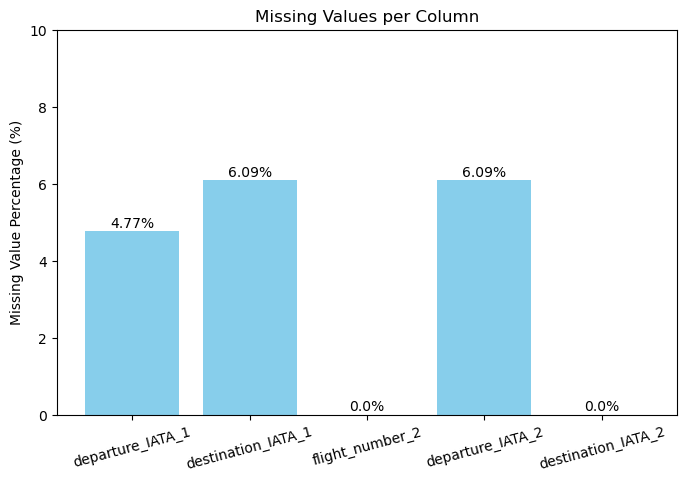

In [13]:
cols = ["departure_IATA_1", "destination_IATA_1", 
        "flight_number_2", "departure_IATA_2", "destination_IATA_2"]

missing_perc = [
    4.77, 6.09, 0.00, 6.09, 0.00
]

plt.figure(figsize=(8,5))
plt.bar(cols, missing_perc, color='skyblue')
plt.ylabel('Missing Value Percentage (%)')
plt.title('Missing Values per Column')
plt.xticks(rotation=15)
plt.ylim(0, 10)
for i, v in enumerate(missing_perc):
    plt.text(i, v+0.1, f"{v}%", ha='center')
plt.show()


### Handle missing values: imputation by relational lookup

In [15]:
# Create a lookup table that maps each flight_number to its known departure_IATA_1 and destination_IATA_1
flight_one_lookup = (
    passengers_eu_df
    .dropna(subset=['flight_number_1', 'departure_IATA_1', 'destination_IATA_1'])
    .drop_duplicates(subset=['flight_number_1'])
    .set_index('flight_number_1')[['departure_IATA_1', 'destination_IATA_1']]
)
display(flight_one_lookup.head())
# Fill missing values by mapping from flight_number_1
def fill_from_lookup(row):
    ''' The function imputes missing departure 1 and destination 1 IATA codes in the dataset based on flight_number_1
    
        Args:
            row: The function takes a complete row from the dataset

        Return:
            row: The funttion returns an updated row

        Example Usage:
            flight_number_1 departure_IATA_1 destination_IATA_1
            CA 6749         ZNZ              NULL
            CA 6749         ZNZ              FRA
            The function will replaces the null value with FRA based on the lookup table
    '''
    if pd.isna(row['departure_IATA_1']) or pd.isna(row['destination_IATA_1']):
        if row['flight_number_1'] in flight_one_lookup.index:
            if pd.isna(row['departure_IATA_1']):
                row['departure_IATA_1'] = flight_one_lookup.loc[row['flight_number_1'], 'departure_IATA_1']
            if pd.isna(row['destination_IATA_1']):
                row['destination_IATA_1'] = flight_one_lookup.loc[row['flight_number_1'], 'destination_IATA_1']
    return row

passengers_eu_df = passengers_eu_df.apply(fill_from_lookup, axis=1)
check_missing_values(passengers_eu_df)

,departure_IATA_1,destination_IATA_1
flight_number_1,,
LH 5507,BCN,KTM
AXM 2562,HGA,MUC
WY 9256,HEL,MCT
MH 8130,VIE,LPL
AC 9128,CPH,MRS


name                         0
sex                          0
birth_date                   0
shopped_at                   0
business_trip                0
traveled_with_family         0
luggage                      0
total_flighttime             0
total_traveltime             0
layover_time                 0
amount_spent_cat             0
flight_number_1              0
departure_IATA_1           174
destination_IATA_1         487
flight_number_2          92268
departure_IATA_2        100324
destination_IATA_2       92268
dtype: int64
Percentage missing departure_IATA_1: 0.13%
Percentage missing destination_IATA_1: 0.37%

Invalid missing values for connecting flights only:
  flight_number_2: 0 rows (0.00%)
  departure_IATA_2: 8056 rows (6.09%)
  destination_IATA_2: 0 rows (0.00%)


In [17]:
# Build lookup table once for flight 2
flight_two_lookup = (
    passengers_eu_df
    .dropna(subset=['flight_number_2', 'departure_IATA_2', 'destination_IATA_2'])
    .drop_duplicates(subset=['flight_number_2'])
    .set_index('flight_number_2')[['departure_IATA_2', 'destination_IATA_2']]
)

def fill_from_lookup_flight2(row):
    ''' The function imputes missing departure 2 and destination 2 IATA codes in the dataset based on flight_number_2
    
        Args:
            row: The function takes a complete row from the dataset

        Return:
            row: The functions returns an updated row

        Example Usage:
            flight_number_2 departure_IATA_2 destination_IATA_2
            CA 6749         ZNZ              NULL
            CA 6749         ZNZ              FRA
            The function will replaces the null value with FRA based on the lookup table
    '''
    
    # Only handle rows where flight_number_2 has a value (indicating a connected flight)
    if not pd.isna(row['flight_number_2']):
        if row['flight_number_2'] in flight_two_lookup.index:
            if pd.isna(row['departure_IATA_2']):
                row['departure_IATA_2'] = flight_two_lookup.loc[row['flight_number_2'], 'departure_IATA_2']
            if pd.isna(row['destination_IATA_2']):
                row['destination_IATA_2'] = flight_two_lookup.loc[row['flight_number_2'], 'destination_IATA_2']
    return row

# Apply
passengers_eu_df = passengers_eu_df.apply(fill_from_lookup_flight2, axis=1)
# Check missing
check_missing_values(passengers_eu_df)

name                        0
sex                         0
birth_date                  0
shopped_at                  0
business_trip               0
traveled_with_family        0
luggage                     0
total_flighttime            0
total_traveltime            0
layover_time                0
amount_spent_cat            0
flight_number_1             0
departure_IATA_1          174
destination_IATA_1        487
flight_number_2         92268
departure_IATA_2        92904
destination_IATA_2      92268
dtype: int64
Percentage missing departure_IATA_1: 0.13%
Percentage missing destination_IATA_1: 0.37%

Invalid missing values for connecting flights only:
  flight_number_2: 0 rows (0.00%)
  departure_IATA_2: 636 rows (0.48%)
  destination_IATA_2: 0 rows (0.00%)


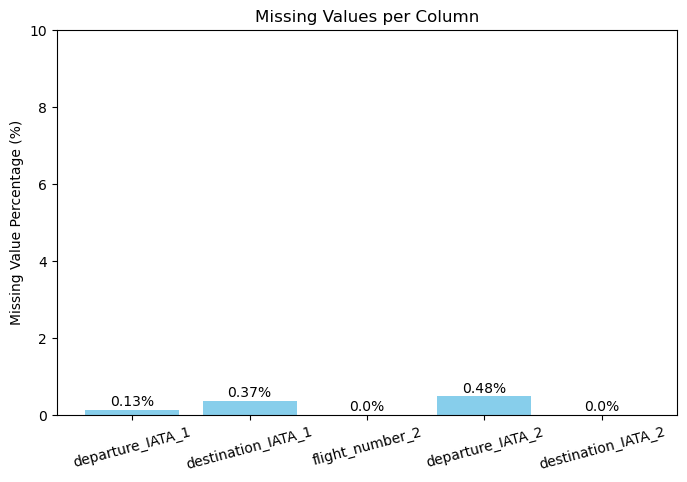

In [19]:
# Visualize missing values per column
cols = ["departure_IATA_1", "destination_IATA_1", 
        "flight_number_2", "departure_IATA_2", "destination_IATA_2"]

missing_perc = [0.13, 0.37, 0.00, 0.48, 0.00]

plt.figure(figsize=(8,5))
plt.bar(cols, missing_perc, color='skyblue')
plt.ylabel('Missing Value Percentage (%)')
plt.title('Missing Values per Column')
plt.xticks(rotation=15)
plt.ylim(0, 10)
for i, v in enumerate(missing_perc):
    plt.text(i, v+0.1, f"{v}%", ha='center')
plt.show()


In [21]:
def drop_flight_1_missing_values(df: pd.DataFrame):
    ''' The fucntion drops missing values with regards to flight 1

        Args:
            df (pd.DataFrame): The function takes a dataframe

        Return:
            None: The function has no return value
    '''
    passengers_eu_df.dropna(
        subset=['departure_IATA_1', 'destination_IATA_1'],
        how='any',
        inplace=True
    )

def drop_flight_2_missing_values(df:pd.DataFrame):
    ''' Drops rows for connecting flights that are only partially filled, inplace

         Args:
            df (pd.DataFrame): The function takes a dataframe

        Return:
            None: The function has no return value
    '''
    mask_keep = df[['flight_number_2', 'departure_IATA_2', 'destination_IATA_2']].notna().all(axis=1) | \
                df[['flight_number_2', 'departure_IATA_2', 'destination_IATA_2']].isna().all(axis=1)
    
    # Drop rows where mask_keep is False
    df.drop(df.index[~mask_keep], inplace=True)
    
# Drop missing values
drop_flight_1_missing_values(passengers_eu_df)
drop_flight_2_missing_values(passengers_eu_df)
# Check again
check_missing_values(passengers_eu_df)
print(passengers_eu_df.shape)

name                        0
sex                         0
birth_date                  0
shopped_at                  0
business_trip               0
traveled_with_family        0
luggage                     0
total_flighttime            0
total_traveltime            0
layover_time                0
amount_spent_cat            0
flight_number_1             0
departure_IATA_1            0
destination_IATA_1          0
flight_number_2         92094
departure_IATA_2        92094
destination_IATA_2      92094
dtype: int64
Percentage missing departure_IATA_1: 0.00%
Percentage missing destination_IATA_1: 0.00%

Invalid missing values for connecting flights only:
  flight_number_2: 0 rows (0.00%)
  departure_IATA_2: 0 rows (0.00%)
  destination_IATA_2: 0 rows (0.00%)
(131165, 17)


In [23]:
# Check for duplicated rows
passengers_eu_df.duplicated().sum()

0

In [25]:
display(passengers_eu_df.head())
print(passengers_eu_df.shape)

,name,sex,birth_date,shopped_at,business_trip,traveled_with_family,luggage,total_flighttime,total_traveltime,layover_time,amount_spent_cat,flight_number_1,departure_IATA_1,destination_IATA_1,flight_number_2,departure_IATA_2,destination_IATA_2
0,Christian Kluge,m,1977/02/28,BCN,yes,no,Sports Bag 19l,550.48,550.48,0.00,2,LH 5507,BCN,KTM,NaN,NaN,NaN
1,Bernd Jung,m,05/10/1971,MUC,no,no,Bag 19kg,1080.14,1142.62,62.48,4,AXM 2562,HGA,MUC,IBE 1195,MUC,OAK
2,Ralph Dewhirst,m,10/04/1984,HEL,no,no,Duffel Bag [31KG],371.48,371.48,0.00,2,WY 9256,HEL,MCT,NaN,NaN,NaN
3,Jan Egger,m,1973/01/21,VIE,no,no,Bag 16kg,148.88,148.88,0.00,2,MH 8130,VIE,LPL,NaN,NaN,NaN
4,Tom Probst,m,31/03/1985,FRA,yes,no,Bag (5KG),1197.70,1655.78,458.08,3,CA 6749,ZNZ,FRA,DL 7477,FRA,MEX


(131165, 17)


### Feature Engineering

In [27]:
# Convert birth_date to datetime
passengers_eu_df['birth_date'] = pd.to_datetime(passengers_eu_df['birth_date'], format='mixed')
print(passengers_eu_df.dtypes)
display(passengers_eu_df.head())

name                            object
sex                             object
birth_date              datetime64[ns]
shopped_at                      object
business_trip                   object
traveled_with_family            object
luggage                         object
total_flighttime               float64
total_traveltime               float64
layover_time                   float64
amount_spent_cat                 int64
flight_number_1                 object
departure_IATA_1                object
destination_IATA_1              object
flight_number_2                 object
departure_IATA_2                object
destination_IATA_2              object
dtype: object


,name,sex,birth_date,shopped_at,business_trip,traveled_with_family,luggage,total_flighttime,total_traveltime,layover_time,amount_spent_cat,flight_number_1,departure_IATA_1,destination_IATA_1,flight_number_2,departure_IATA_2,destination_IATA_2
0,Christian Kluge,m,1977-02-28,BCN,yes,no,Sports Bag 19l,550.48,550.48,0.00,2,LH 5507,BCN,KTM,NaN,NaN,NaN
1,Bernd Jung,m,1971-05-10,MUC,no,no,Bag 19kg,1080.14,1142.62,62.48,4,AXM 2562,HGA,MUC,IBE 1195,MUC,OAK
2,Ralph Dewhirst,m,1984-10-04,HEL,no,no,Duffel Bag [31KG],371.48,371.48,0.00,2,WY 9256,HEL,MCT,NaN,NaN,NaN
3,Jan Egger,m,1973-01-21,VIE,no,no,Bag 16kg,148.88,148.88,0.00,2,MH 8130,VIE,LPL,NaN,NaN,NaN
4,Tom Probst,m,1985-03-31,FRA,yes,no,Bag (5KG),1197.70,1655.78,458.08,3,CA 6749,ZNZ,FRA,DL 7477,FRA,MEX


In [29]:
# Check data types for each column for each dataset
print(passengers_eu_df.dtypes)

name                            object
sex                             object
birth_date              datetime64[ns]
shopped_at                      object
business_trip                   object
traveled_with_family            object
luggage                         object
total_flighttime               float64
total_traveltime               float64
layover_time                   float64
amount_spent_cat                 int64
flight_number_1                 object
departure_IATA_1                object
destination_IATA_1              object
flight_number_2                 object
departure_IATA_2                object
destination_IATA_2              object
dtype: object


In [31]:
# Parsing the luggage column
def parse_luggage(luggage: str)->pd.Series:
    '''The function parses the luggage column
       Args:
           luggage (str): it takes the luggage column as an input
        Return:
            [luggage_type, luggage_size, luggage_unit] (pd.Series): it returns the luggage type, size and the size unit
    '''
    # Extract the luugage type (everything before the first number and without special characters)
    luggage_type_matching = re.match(r'^([^\d]+)', luggage)
    luggage_type = luggage_type_matching.group(1).strip() if luggage_type_matching else None

    # Remove any special characters like brackets
    luggage_type = re.sub(r'[\[\]\(\)]', '', luggage_type).strip()

    # Extract the size
    size_matching = re.search(r'(\d+)', luggage)
    luggage_size = int(size_matching.group(1)) if size_matching else None

    # Extract the luggage unit
    unit_matching = re.search(r'\d+\s*[\[\(\{]*\s*([a-zA-Z]+)', luggage)
    luggage_unit = unit_matching.group(1).lower() if unit_matching else None
    
    return pd.Series([luggage_type, luggage_size, luggage_unit])

passengers_eu_df[['luggage_type', 'luggage_size', 'luggage_size_unit']] = passengers_eu_df['luggage'].apply(parse_luggage)
# Drop the original column
passengers_eu_df.drop('luggage', axis=1, inplace=True)
display(passengers_eu_df.head(15))

,name,sex,birth_date,shopped_at,business_trip,traveled_with_family,total_flighttime,total_traveltime,layover_time,amount_spent_cat,flight_number_1,departure_IATA_1,destination_IATA_1,flight_number_2,departure_IATA_2,destination_IATA_2,luggage_type,luggage_size,luggage_size_unit
0,Christian Kluge,m,1977-02-28,BCN,yes,no,550.48,550.48,0.00,2,LH 5507,BCN,KTM,NaN,NaN,NaN,Sports Bag,19,l
1,Bernd Jung,m,1971-05-10,MUC,no,no,1080.14,1142.62,62.48,4,AXM 2562,HGA,MUC,IBE 1195,MUC,OAK,Bag,19,kg
2,Ralph Dewhirst,m,1984-10-04,HEL,no,no,371.48,371.48,0.00,2,WY 9256,HEL,MCT,NaN,NaN,NaN,Duffel Bag,31,kg
3,Jan Egger,m,1973-01-21,VIE,no,no,148.88,148.88,0.00,2,MH 8130,VIE,LPL,NaN,NaN,NaN,Bag,16,kg
4,Tom Probst,m,1985-03-31,FRA,yes,no,1197.70,1655.78,458.08,3,CA 6749,ZNZ,FRA,DL 7477,FRA,MEX,Bag,5,kg
5,Swen Zweig,m,1971-07-13,CPH,no,no,147.03,147.03,0.00,1,AC 9128,CPH,MRS,NaN,NaN,NaN,Messenger Bag,1,kg
6,Stefan Jaeger,m,1994-03-04,LHR,yes,no,751.48,826.48,75.00,3,BEL 7205,HND,LHR,VA 6925,LHR,BRS,Purse,2,l
7,Florina adriana Ledo,f,1966-08-04,MUC,no,no,676.52,754.92,78.40,2,FDB 3614,FCO,MUC,AE 2698,MUC,NAS,Bag,19,l
8,Wouter Samit,m,1987-08-24,HEL,no,no,762.16,862.48,100.32,3,AC 1222,AMS,HEL,AE 0782,HEL,DFW,Trolley,11,kg
9,Anne Wannemaker,f,1992-04-24,ZRH,yes,no,953.05,1554.82,601.77,3,JBU 9075,TFS,ZRH,JL 3897,ZRH,SGN,Suitcase,10,l


In [33]:
# Convert luggage_size to Kilograms
print(passengers_eu_df['luggage_size_unit'].unique())

def convert_2_kg(row):
    ''' The function converts luggage size into kilograms

        Args:
            row: it takes a complete row from the dataframe

        Returns:
            None: The function returns none
    '''
    size = row['luggage_size']
    unit = row['luggage_size_unit']

    if unit == 'kg':
        return size
    elif unit == 'l':
        return size
    elif unit == 'lbs':
        return size * 0.453592
    else:
        return size

passengers_eu_df['luggage_size (kg)'] = passengers_eu_df.apply(convert_2_kg, axis=1)

# Delete original columns
passengers_eu_df.drop(columns=['luggage_size', 'luggage_size_unit'], inplace=True) 

display(passengers_eu_df.head(15))
print(passengers_eu_df.shape)

['l' 'kg' 'lbs']


,name,sex,birth_date,shopped_at,business_trip,traveled_with_family,total_flighttime,total_traveltime,layover_time,amount_spent_cat,flight_number_1,departure_IATA_1,destination_IATA_1,flight_number_2,departure_IATA_2,destination_IATA_2,luggage_type,luggage_size (kg)
0,Christian Kluge,m,1977-02-28,BCN,yes,no,550.48,550.48,0.00,2,LH 5507,BCN,KTM,NaN,NaN,NaN,Sports Bag,19.000000
1,Bernd Jung,m,1971-05-10,MUC,no,no,1080.14,1142.62,62.48,4,AXM 2562,HGA,MUC,IBE 1195,MUC,OAK,Bag,19.000000
2,Ralph Dewhirst,m,1984-10-04,HEL,no,no,371.48,371.48,0.00,2,WY 9256,HEL,MCT,NaN,NaN,NaN,Duffel Bag,31.000000
3,Jan Egger,m,1973-01-21,VIE,no,no,148.88,148.88,0.00,2,MH 8130,VIE,LPL,NaN,NaN,NaN,Bag,16.000000
4,Tom Probst,m,1985-03-31,FRA,yes,no,1197.70,1655.78,458.08,3,CA 6749,ZNZ,FRA,DL 7477,FRA,MEX,Bag,5.000000
5,Swen Zweig,m,1971-07-13,CPH,no,no,147.03,147.03,0.00,1,AC 9128,CPH,MRS,NaN,NaN,NaN,Messenger Bag,1.000000
6,Stefan Jaeger,m,1994-03-04,LHR,yes,no,751.48,826.48,75.00,3,BEL 7205,HND,LHR,VA 6925,LHR,BRS,Purse,2.000000
7,Florina adriana Ledo,f,1966-08-04,MUC,no,no,676.52,754.92,78.40,2,FDB 3614,FCO,MUC,AE 2698,MUC,NAS,Bag,19.000000
8,Wouter Samit,m,1987-08-24,HEL,no,no,762.16,862.48,100.32,3,AC 1222,AMS,HEL,AE 0782,HEL,DFW,Trolley,11.000000
9,Anne Wannemaker,f,1992-04-24,ZRH,yes,no,953.05,1554.82,601.77,3,JBU 9075,TFS,ZRH,JL 3897,ZRH,SGN,Suitcase,10.000000


(131165, 18)


In [102]:
# Check for missing airport codes in the airports dataset to calculate the distance

# Load both Excel files
missing_iata = pd.read_excel("missing_iata_codes.xlsx")
airport_codes = pd.read_csv("airport-codes.csv")

# Merge on iata_code
# Assuming missing_iata['airport_code'] corresponds to airport_codes['iata_code']
merged_df = missing_iata.merge(
    airport_codes[['name','continent', 'iso_country','iata_code', 'coordinates']],
    left_on='airport_code',
    right_on='iata_code',
    how='left'
)

# Drop duplicate iata_code column (if needed)
merged_df.drop(columns=['iata_code'], inplace=True)
display(merged_df)
# Save the enriched file
merged_df.to_excel("missing_iata_with_country_continent.xlsx", index=False)

,airport_code,name,continent,iso_country,coordinates
0,HGA,Egal International Airport,AF,SO,"9.513207, 44.082389"
1,TFS,Tenerife Sur Airport,AF,ES,"28.0445, -16.5725"
2,ADD,Addis Ababa Bole International Airport,AF,ET,"8.97789, 38.799301"
3,GRU,Guarulhos - Governador André Franco Montoro In...,SA,BR,"-23.431944, -46.467778"
4,LJU,Ljubljana Jože Pučnik Airport,EU,SI,"46.223701, 14.4576"
...,...,...,...,...,...
153,BOM,Chhatrapati Shivaji International Airport,AS,IN,"19.0886993408, 72.8678970337"
154,PHX,Phoenix Sky Harbor International Airport,NaN,US,"33.435302, -112.005905"
155,MEX,Benito Juárez International Airport,NaN,MX,"19.435137, -99.071328"
156,CNX,Chiang Mai International Airport,AS,TH,"18.766799926799997, 98.962600708"


In [35]:
# Calculate the distance between departure and destination as an additional feature
missing_airport_codes = pd.read_excel('missing_iata_with_country_continent.xlsx')

df_combined = pd.concat([missing_airport_codes, airports_df], ignore_index=True)
display(df_combined.head())

,iata_code,name,continent,iso_country,coordinates
0,HGA,Egal International Airport,AF,SO,"9.513207, 44.082389"
1,TFS,Tenerife Sur Airport,AF,ES,"28.0445, -16.5725"
2,ADD,Addis Ababa Bole International Airport,AF,ET,"8.97789, 38.799301"
3,GRU,Guarulhos - Governador André Franco Montoro In...,SA,BR,"-23.431944, -46.467778"
4,LJU,Ljubljana Jože Pučnik Airport,EU,SI,"46.223701, 14.4576"


In [37]:
def haversine(lat1, lon1, lat2, lon2):
    # Convert degrees to radians
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    # Haversine formula
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat / 2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2)**2
    c = 2 * np.arcsin(np.sqrt(a))
    r = 6371  # Earth radius in km
    return c * r

# Split coordinates into numeric lat/lon
df_combined[['lat', 'lon']] = df_combined['coordinates'].str.split(',', expand=True)
df_combined['lat'] = df_combined['lat'].astype(float)
df_combined['lon'] = df_combined['lon'].astype(float)

# Create lookup dicts
iata_lat = df_combined.set_index('iata_code')['lat']
iata_lon = df_combined.set_index('iata_code')['lon']

# 4. Determine final destination based on direct vs connecting
passengers_eu_df['final_dest'] = np.where(
    passengers_eu_df['flight_number_2'].isna(),
    passengers_eu_df['destination_IATA_1'],  # direct
    passengers_eu_df['destination_IATA_2']   # connecting
)

# 5. Map coordinates
passengers_eu_df['dep_lat'] = passengers_eu_df['departure_IATA_1'].map(iata_lat)
passengers_eu_df['dep_lon'] = passengers_eu_df['departure_IATA_1'].map(iata_lon)
passengers_eu_df['dest_lat'] = passengers_eu_df['final_dest'].map(iata_lat)
passengers_eu_df['dest_lon'] = passengers_eu_df['final_dest'].map(iata_lon)

# 6. Calculate distance
passengers_eu_df['distance (km)'] = haversine(
    passengers_eu_df['dep_lat'], passengers_eu_df['dep_lon'],
    passengers_eu_df['dest_lat'], passengers_eu_df['dest_lon']
).round(0)

# 7. Cleanup temporary columns
passengers_eu_df.drop(columns=['dep_lat', 'dep_lon', 'dest_lat', 'dest_lon', 'final_dest'], inplace=True)

In [39]:
display(passengers_eu_df.head())

,name,sex,birth_date,shopped_at,business_trip,traveled_with_family,total_flighttime,total_traveltime,layover_time,amount_spent_cat,flight_number_1,departure_IATA_1,destination_IATA_1,flight_number_2,departure_IATA_2,destination_IATA_2,luggage_type,luggage_size (kg),distance (km)
0,Christian Kluge,m,1977-02-28,BCN,yes,no,550.48,550.48,0.00,2,LH 5507,BCN,KTM,NaN,NaN,NaN,Sports Bag,19.0,7493.0
1,Bernd Jung,m,1971-05-10,MUC,no,no,1080.14,1142.62,62.48,4,AXM 2562,HGA,MUC,IBE 1195,MUC,OAK,Bag,19.0,14573.0
2,Ralph Dewhirst,m,1984-10-04,HEL,no,no,371.48,371.48,0.00,2,WY 9256,HEL,MCT,NaN,NaN,NaN,Duffel Bag,31.0,4823.0
3,Jan Egger,m,1973-01-21,VIE,no,no,148.88,148.88,0.00,2,MH 8130,VIE,LPL,NaN,NaN,NaN,Bag,16.0,1479.0
4,Tom Probst,m,1985-03-31,FRA,yes,no,1197.70,1655.78,458.08,3,CA 6749,ZNZ,FRA,DL 7477,FRA,MEX,Bag,5.0,15277.0


In [41]:
# Since data was evaluated on 31.12.2019, it will be used as ref to extract the age
ref_date = datetime(2019, 12, 31)
passengers_eu_df['age'] = passengers_eu_df['birth_date'].apply(
    lambda birth_date: (ref_date - birth_date).days // 365
)
display(passengers_eu_df.head())

,name,sex,birth_date,shopped_at,business_trip,traveled_with_family,total_flighttime,total_traveltime,layover_time,amount_spent_cat,flight_number_1,departure_IATA_1,destination_IATA_1,flight_number_2,departure_IATA_2,destination_IATA_2,luggage_type,luggage_size (kg),distance (km),age
0,Christian Kluge,m,1977-02-28,BCN,yes,no,550.48,550.48,0.00,2,LH 5507,BCN,KTM,NaN,NaN,NaN,Sports Bag,19.0,7493.0,42
1,Bernd Jung,m,1971-05-10,MUC,no,no,1080.14,1142.62,62.48,4,AXM 2562,HGA,MUC,IBE 1195,MUC,OAK,Bag,19.0,14573.0,48
2,Ralph Dewhirst,m,1984-10-04,HEL,no,no,371.48,371.48,0.00,2,WY 9256,HEL,MCT,NaN,NaN,NaN,Duffel Bag,31.0,4823.0,35
3,Jan Egger,m,1973-01-21,VIE,no,no,148.88,148.88,0.00,2,MH 8130,VIE,LPL,NaN,NaN,NaN,Bag,16.0,1479.0,46
4,Tom Probst,m,1985-03-31,FRA,yes,no,1197.70,1655.78,458.08,3,CA 6749,ZNZ,FRA,DL 7477,FRA,MEX,Bag,5.0,15277.0,34


In [45]:
# New Column: num_flights
passengers_eu_df['num_flights'] = passengers_eu_df.apply(
    lambda row: 1 if (
        pd.isna(row['flight_number_2']) and 
        pd.isna(row['departure_IATA_2']) and 
        pd.isna(row['destination_IATA_2'])
    ) else 2,
    axis=1
)

# Check the new feature
display(passengers_eu_df.head(10))

,name,sex,birth_date,shopped_at,business_trip,traveled_with_family,total_flighttime,total_traveltime,layover_time,amount_spent_cat,...,departure_IATA_1,destination_IATA_1,flight_number_2,departure_IATA_2,destination_IATA_2,luggage_type,luggage_size (kg),distance (km),age,num_flights
0,Christian Kluge,m,1977-02-28,BCN,yes,no,550.48,550.48,0.00,2,...,BCN,KTM,NaN,NaN,NaN,Sports Bag,19.0,7493.0,42,1
1,Bernd Jung,m,1971-05-10,MUC,no,no,1080.14,1142.62,62.48,4,...,HGA,MUC,IBE 1195,MUC,OAK,Bag,19.0,14573.0,48,2
2,Ralph Dewhirst,m,1984-10-04,HEL,no,no,371.48,371.48,0.00,2,...,HEL,MCT,NaN,NaN,NaN,Duffel Bag,31.0,4823.0,35,1
3,Jan Egger,m,1973-01-21,VIE,no,no,148.88,148.88,0.00,2,...,VIE,LPL,NaN,NaN,NaN,Bag,16.0,1479.0,46,1
4,Tom Probst,m,1985-03-31,FRA,yes,no,1197.70,1655.78,458.08,3,...,ZNZ,FRA,DL 7477,FRA,MEX,Bag,5.0,15277.0,34,2
5,Swen Zweig,m,1971-07-13,CPH,no,no,147.03,147.03,0.00,1,...,CPH,MRS,NaN,NaN,NaN,Messenger Bag,1.0,1455.0,48,1
6,Stefan Jaeger,m,1994-03-04,LHR,yes,no,751.48,826.48,75.00,3,...,HND,LHR,VA 6925,LHR,BRS,Purse,2.0,9680.0,25,2
7,Florina adriana Ledo,f,1966-08-04,MUC,no,no,676.52,754.92,78.40,2,...,FCO,MUC,AE 2698,MUC,NAS,Bag,19.0,8162.0,53,2
8,Wouter Samit,m,1987-08-24,HEL,no,no,762.16,862.48,100.32,3,...,AMS,HEL,AE 0782,HEL,DFW,Trolley,11.0,7900.0,32,2
9,Anne Wannemaker,f,1992-04-24,ZRH,yes,no,953.05,1554.82,601.77,3,...,TFS,ZRH,JL 3897,ZRH,SGN,Suitcase,10.0,12537.0,27,2


In [289]:
flight_info = passengers_eu_df[['name', 'flight_number_1', 'flight_number_2', 'num_flights']]
display(flight_info.head(10))

,name,flight_number_1,flight_number_2,num_flights
0,Christian Kluge,LH 5507,NaN,1
1,Bernd Jung,AXM 2562,IBE 1195,2
2,Ralph Dewhirst,WY 9256,NaN,1
3,Jan Egger,MH 8130,NaN,1
5,Swen Zweig,AC 9128,NaN,1
6,Stefan Jaeger,BEL 7205,VA 6925,2
7,Florina adriana Ledo,FDB 3614,AE 2698,2
8,Wouter Samit,AC 1222,AE 0782,2
11,Nolan Dieterich,MH 8744,NaN,1
12,Carmelita Kinnick,FDB 5641,EW 4583,2


### Outliers Detection

In [373]:
def detect_outliers_report(df):
    report = {}

    # (IQR method)
    num_cols = df.select_dtypes(include=[np.number]).columns
    for col in num_cols:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        
        lower = Q1 - 1.5 * IQR
        upper = Q3 + 1.5 * IQR
        
        outliers = df[(df[col] < lower) | (df[col] > upper)]
        report[col] = {
            "type": "numerical",
            "outlier_count": len(outliers),
            "outlier_percentage": round(len(outliers) / len(df) * 100, 2),
            "min": df[col].min(),
            "max": df[col].max(),
            "lower_bound": lower,
            "upper_bound": upper
        }


    return report

outlier_summary = detect_outliers_report(passengers_eu_df)

In [375]:
outlier_df = pd.DataFrame(outlier_summary).T.reset_index()
outlier_df.rename(columns={"index": "Column"}, inplace=True)

display(outlier_df)

,Column,type,outlier_count,outlier_percentage,min,max,lower_bound,upper_bound
0,total_flighttime,numerical,0,0.0,52.55,1366.64,-534.94,1472.9
1,total_traveltime,numerical,1108,0.84,52.55,2244.92,-754.575,1841.225
2,layover_time,numerical,15898,12.12,0.0,886.0,-189.495,315.825
3,amount_spent_cat,numerical,0,0.0,0,4,-4.5,7.5
4,luggage_size (kg),numerical,0,0.0,0.453592,31.0,-17.0,39.0
5,distance (km),numerical,3,0.0,38.0,19316.0,-7615.0,19169.0
6,age,numerical,2603,1.98,18,170,2.5,78.5
7,num_flights,numerical,0,0.0,1,2,-0.5,3.5


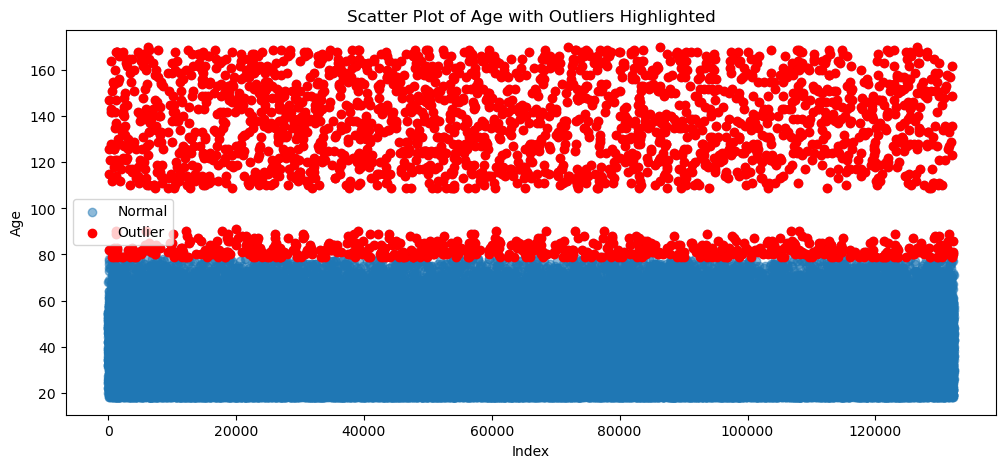

In [189]:
# Calculate IQR bounds
Q1 = passengers_eu_df['age'].quantile(0.25)
Q3 = passengers_eu_df['age'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Create a boolean mask for outliers
outliers_mask = (passengers_eu_df['age'] < lower_bound) | (passengers_eu_df['age'] > upper_bound)

plt.figure(figsize=(12, 5))

# Scatter plot of all ages
plt.scatter(passengers_eu_df.index, passengers_eu_df['age'], alpha=0.5, label='Normal')

# Highlight outliers in red
plt.scatter(passengers_eu_df.index[outliers_mask], passengers_eu_df['age'][outliers_mask], 
            color='red', label='Outlier')

plt.xlabel('Index')
plt.ylabel('Age')
plt.title('Scatter Plot of Age with Outliers Highlighted')
plt.legend()
plt.show()

C:\Users\User\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


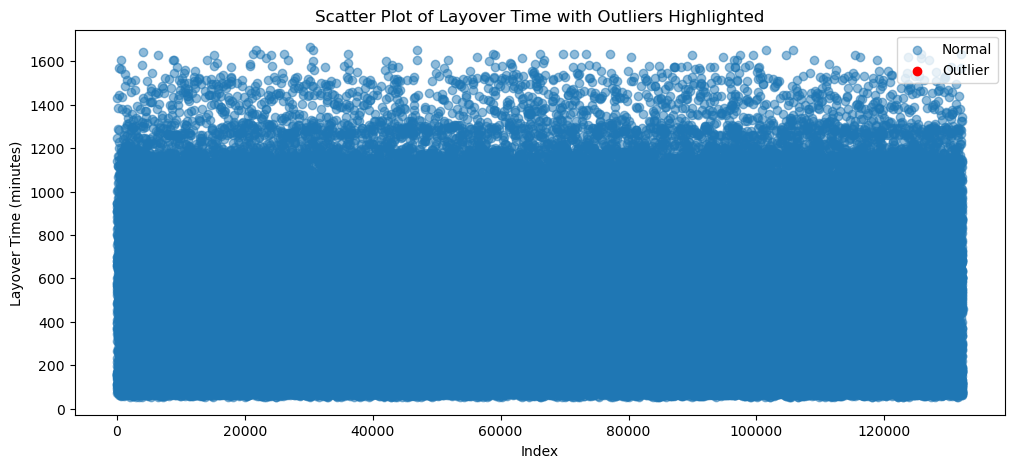

In [323]:
# Calculate IQR bounds for layover_time
Q1 = passengers_eu_df['total_traveltime'].quantile(0.01)
Q3 = passengers_eu_df['total_traveltime'].quantile(0.99)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Boolean mask for outliers
outliers_mask = (passengers_eu_df['total_traveltime'] < lower_bound) | (passengers_eu_df['total_traveltime'] > upper_bound)

plt.figure(figsize=(12, 5))

# Scatter plot of all layover times
plt.scatter(passengers_eu_df.index, passengers_eu_df['total_traveltime'], alpha=0.5, label='Normal')

# Highlight outliers in red
plt.scatter(passengers_eu_df.index[outliers_mask], passengers_eu_df['total_traveltime'][outliers_mask], 
            color='red', label='Outlier')

plt.xlabel('Index')
plt.ylabel('Layover Time (minutes)')
plt.title('Scatter Plot of Layover Time with Outliers Highlighted')
plt.legend()
plt.show()


In [379]:
def remove_outliers(df, columns=None):
    """
    Remove outliers from specified numerical columns using the IQR method.
    Keeps all categorical columns.
    """
    clean_df = df.copy()
    
    if columns is None:
        columns = clean_df.select_dtypes(include=[np.number]).columns
    
    # Initialize mask of True (keep all rows initially)
    mask = pd.Series(True, index=clean_df.index)
    
    for col in columns:
        Q1 = clean_df[col].quantile(0.25)
        Q3 = clean_df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower = Q1 - 1.5 * IQR
        upper = Q3 + 1.5 * IQR
        
        # Update mask: keep rows within bounds for this column
        mask &= (clean_df[col] >= lower) & (clean_df[col] <= upper)
    
    # Apply mask once
    clean_df = clean_df[mask]
    
    return clean_df

# Usage
passengers_eu_df_out = remove_outliers(passengers_eu_df)
print(f"Cleaned shape: {passengers_eu_df_out.shape}")
display(passengers_eu_df_out.head())

Cleaned shape: (112952, 21)


,name,sex,birth_date,shopped_at,business_trip,traveled_with_family,total_flighttime,total_traveltime,layover_time,amount_spent_cat,...,departure_IATA_1,destination_IATA_1,flight_number_2,departure_IATA_2,destination_IATA_2,luggage_type,luggage_size (kg),distance (km),age,num_flights
0,Christian Kluge,m,1977-02-28,BCN,yes,no,550.48,550.48,0.00,2,...,BCN,KTM,NaN,NaN,NaN,Sports Bag,19.0,7493.0,42,1
1,Bernd Jung,m,1971-05-10,MUC,no,no,1080.14,1142.62,62.48,4,...,HGA,MUC,IBE 1195,MUC,OAK,Bag,19.0,14573.0,48,2
2,Ralph Dewhirst,m,1984-10-04,HEL,no,no,371.48,371.48,0.00,2,...,HEL,MCT,NaN,NaN,NaN,Duffel Bag,31.0,4823.0,35,1
3,Jan Egger,m,1973-01-21,VIE,no,no,148.88,148.88,0.00,2,...,VIE,LPL,NaN,NaN,NaN,Bag,16.0,1479.0,46,1
5,Swen Zweig,m,1971-07-13,CPH,no,no,147.03,147.03,0.00,1,...,CPH,MRS,NaN,NaN,NaN,Messenger Bag,1.0,1455.0,48,1


### Data Visualizations

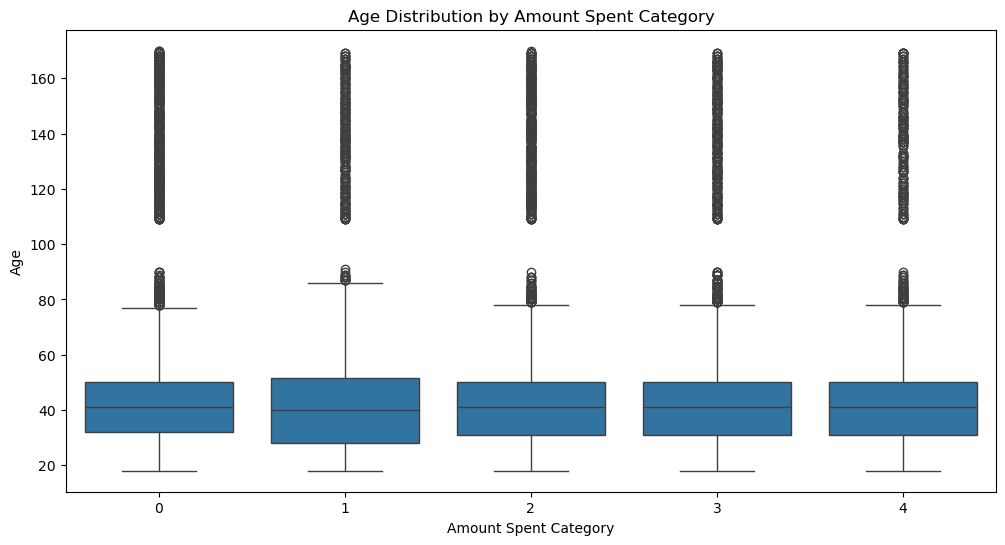

In [47]:
plt.figure(figsize=(12,6))
sns.boxplot(x='amount_spent_cat', y='age', data=passengers_eu_df)
plt.xlabel('Amount Spent Category')
plt.ylabel('Age')
plt.title('Age Distribution by Amount Spent Category')
plt.show()


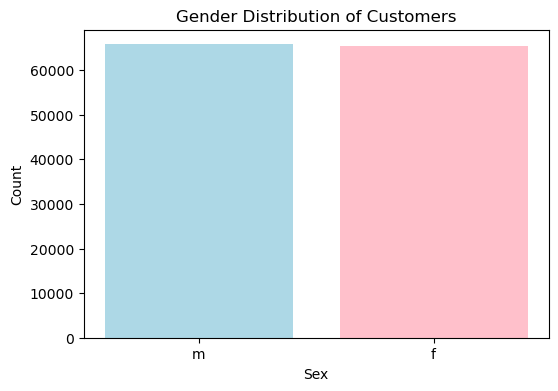

In [387]:
# Sex Distribution
plt.figure(figsize=(6,4))
sex_counts = passengers_eu_df['sex'].value_counts()
plt.bar(sex_counts.index, sex_counts.values, color=['lightblue', 'pink'])
plt.title('Gender Distribution of Customers')
plt.xlabel('Sex')
plt.ylabel('Count')
plt.show()

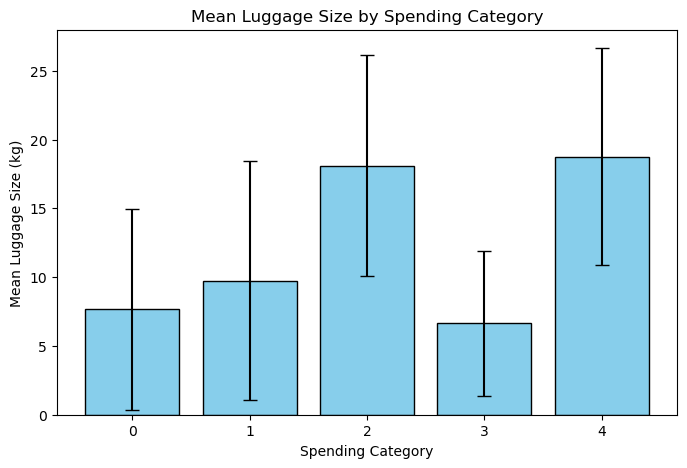

In [115]:
# Luggage Size by Spending Category (Boxplot)
# Calculate mean and std luggage size by spending category
grouped = passengers_eu_df.groupby('amount_spent_cat')['luggage_size (kg)'].agg(['mean', 'std']).reset_index()

plt.figure(figsize=(8,5))
plt.bar(grouped['amount_spent_cat'], grouped['mean'], yerr=grouped['std'], capsize=5, color='skyblue', edgecolor='black')
plt.title('Mean Luggage Size by Spending Category')
plt.xlabel('Spending Category')
plt.ylabel('Mean Luggage Size (kg)')
plt.xticks(grouped['amount_spent_cat'])
plt.show()

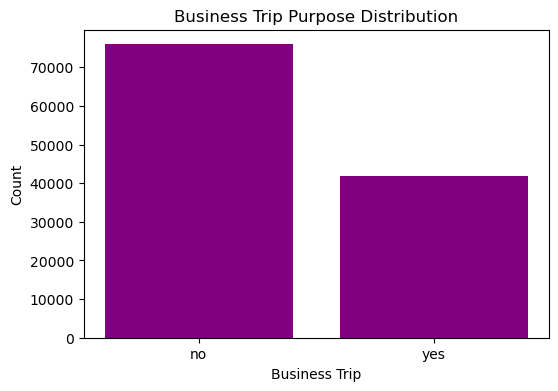

In [117]:
# 4. Business Trip Distribution
plt.figure(figsize=(6,4))
business_counts = passengers_eu_df['business_trip'].value_counts()
plt.bar(business_counts.index, business_counts.values, color='purple')
plt.title('Business Trip Purpose Distribution')
plt.xlabel('Business Trip')
plt.ylabel('Count')
plt.show()

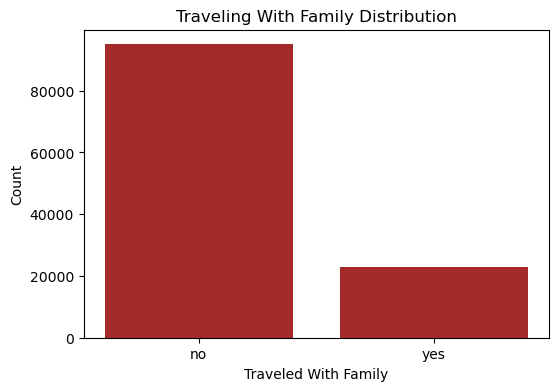

In [119]:
# Traveling With Family Distribution
plt.figure(figsize=(6,4))
family_counts = passengers_eu_df['traveled_with_family'].value_counts()
plt.bar(family_counts.index, family_counts.values, color='brown')
plt.title('Traveling With Family Distribution')
plt.xlabel('Traveled With Family')
plt.ylabel('Count')
plt.show()

,name,birth_date,shopped_at,total_flighttime,total_traveltime,layover_time,amount_spent_cat,flight_number_1,departure_IATA_1,destination_IATA_1,...,luggage_size (kg),distance (km),age,num_flights,sex_f,sex_m,business_trip_no,business_trip_yes,traveled_with_family_no,traveled_with_family_yes
0,Christian Kluge,1977-02-28,BCN,550.48,550.48,0.00,2,LH 5507,BCN,KTM,...,19.0,7493.0,42,1,False,True,False,True,True,False
1,Bernd Jung,1971-05-10,MUC,1080.14,1142.62,62.48,4,AXM 2562,HGA,MUC,...,19.0,14573.0,48,2,False,True,True,False,True,False
2,Ralph Dewhirst,1984-10-04,HEL,371.48,371.48,0.00,2,WY 9256,HEL,MCT,...,31.0,4823.0,35,1,False,True,True,False,True,False
3,Jan Egger,1973-01-21,VIE,148.88,148.88,0.00,2,MH 8130,VIE,LPL,...,16.0,1479.0,46,1,False,True,True,False,True,False
4,Tom Probst,1985-03-31,FRA,1197.70,1655.78,458.08,3,CA 6749,ZNZ,FRA,...,5.0,15277.0,34,2,False,True,False,True,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
132229,Martin Cluckey,1990-05-15,CDG,1000.90,1000.90,0.00,0,EY 1046,PER,CDG,...,21.0,14273.0,29,1,True,False,True,False,False,True
132230,Florina ramona Bande,1983-09-23,MUC,340.52,477.60,137.08,2,KLM 7275,MSQ,MUC,...,30.0,3602.0,36,2,True,False,False,True,True,False
132231,Samara Zonia,1971-10-08,FCO,671.19,746.37,75.18,1,AY 7165,CMB,FCO,...,9.0,7671.0,48,2,True,False,True,False,True,False
132232,Kizkitza Archidona,1993-03-22,MUC,131.08,131.08,0.00,0,LH 8939,MUC,PMI,...,9.0,1216.0,26,1,True,False,False,True,True,False


,total_flighttime,total_traveltime,layover_time,amount_spent_cat,luggage_size (kg),distance (km),age,num_flights,sex_f,sex_m,business_trip_no,business_trip_yes,traveled_with_family_no,traveled_with_family_yes
0,550.48,550.48,0.00,2,19.0,7493.0,42,1,False,True,False,True,True,False
1,1080.14,1142.62,62.48,4,19.0,14573.0,48,2,False,True,True,False,True,False
2,371.48,371.48,0.00,2,31.0,4823.0,35,1,False,True,True,False,True,False
3,148.88,148.88,0.00,2,16.0,1479.0,46,1,False,True,True,False,True,False
4,1197.70,1655.78,458.08,3,5.0,15277.0,34,2,False,True,False,True,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
132229,1000.90,1000.90,0.00,0,21.0,14273.0,29,1,True,False,True,False,False,True
132230,340.52,477.60,137.08,2,30.0,3602.0,36,2,True,False,False,True,True,False
132231,671.19,746.37,75.18,1,9.0,7671.0,48,2,True,False,True,False,True,False
132232,131.08,131.08,0.00,0,9.0,1216.0,26,1,True,False,False,True,True,False


******************Correlation Matrix*****************


,total_flighttime,total_traveltime,layover_time,amount_spent_cat,luggage_size (kg),distance (km),age,num_flights,sex_f,sex_m,business_trip_no,business_trip_yes,traveled_with_family_no,traveled_with_family_yes
total_flighttime,1.000000,0.949622,0.574501,0.528618,-0.003094,0.966600,0.001557,0.571184,0.000066,-0.000066,-0.003737,0.003737,0.004584,-0.004584
total_traveltime,0.949622,1.000000,0.802075,0.642363,-0.004331,0.871179,0.000036,0.738717,-0.000233,0.000233,-0.002868,0.002868,0.004174,-0.004174
layover_time,0.574501,0.802075,1.000000,0.670313,-0.005415,0.433276,-0.002874,0.840848,-0.000735,0.000735,-0.000368,0.000368,0.002165,-0.002165
amount_spent_cat,0.528618,0.642363,0.670313,1.000000,0.296157,0.415894,-0.005426,0.721490,0.000603,-0.000603,0.092548,-0.092548,0.078424,-0.078424
luggage_size (kg),-0.003094,-0.004331,-0.005415,0.296157,1.000000,-0.002269,-0.000556,-0.004368,-0.003459,0.003459,-0.002946,0.002946,0.003331,-0.003331
distance (km),0.966600,0.871179,0.433276,0.415894,-0.002269,1.000000,0.002325,0.401954,0.000831,-0.000831,-0.003946,0.003946,0.005135,-0.005135
age,0.001557,0.000036,-0.002874,-0.005426,-0.000556,0.002325,1.000000,-0.002611,0.002035,-0.002035,-0.033110,0.033110,0.006768,-0.006768
num_flights,0.571184,0.738717,0.840848,0.721490,-0.004368,0.401954,-0.002611,1.000000,0.000740,-0.000740,-0.001279,0.001279,0.001457,-0.001457
sex_f,0.000066,-0.000233,-0.000735,0.000603,-0.003459,0.000831,0.002035,0.000740,1.000000,-1.000000,0.001391,-0.001391,-0.000562,0.000562
sex_m,-0.000066,0.000233,0.000735,-0.000603,0.003459,-0.000831,-0.002035,-0.000740,-1.000000,1.000000,-0.001391,0.001391,0.000562,-0.000562


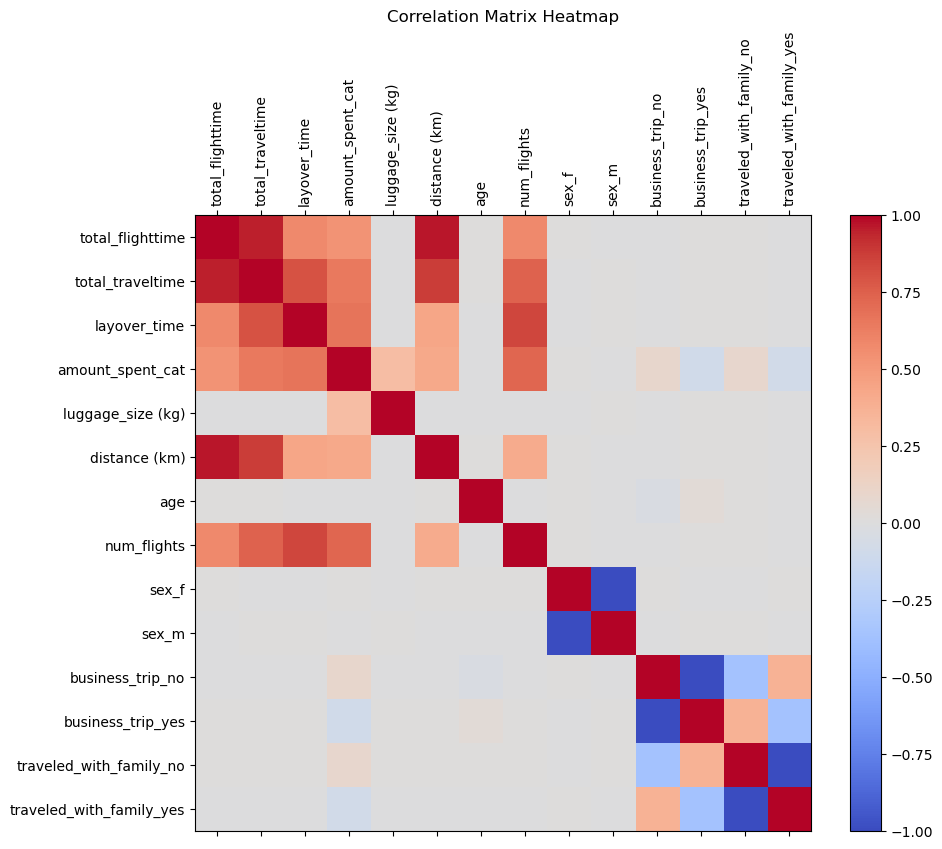

In [389]:
# One Hot Encoding for categorical data
categorical_cols = ['sex', 'business_trip', 'traveled_with_family']
df_encoded = pd.get_dummies(passengers_eu_df, columns=categorical_cols, drop_first=False)
display(df_encoded)

# Display the correlation matrix for the numeric values
numeric_df = df_encoded.select_dtypes(include=[np.number, 'bool'])
display(numeric_df)

#numeric_df = passengers_eu_df.select_dtypes(include=['number','float64'])
corr = numeric_df.corr()
print('******************Correlation Matrix*****************')
display(corr)


fig, ax = plt.subplots(figsize=(10, 8))
cax = ax.matshow(corr, cmap='coolwarm')

# Add colorbar
fig.colorbar(cax)

# Set ticks and labels
ticks = np.arange(len(corr.columns))
ax.set_xticks(ticks)
ax.set_yticks(ticks)
ax.set_xticklabels(corr.columns, rotation=90)
ax.set_yticklabels(corr.columns)

plt.title('Correlation Matrix Heatmap')

# Save the figure as PNG
plt.savefig('correlation_heatmap.png', dpi=300, bbox_inches='tight')

plt.show()

## Model Training

In [57]:
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.impute import KNNImputer
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.under_sampling import RandomUnderSampler

from collections import Counter

display(passengers_eu_df.head())

### Dataset without Low Correlated Features

In [53]:
# SELECT Features to be trained
dataset_low = passengers_eu_df[['num_flights', 'luggage_size (kg)', 'layover_time', 'total_traveltime','amount_spent_cat']]
display(dataset_low.head())
print(dataset_low.dtypes)

,num_flights,luggage_size (kg),layover_time,total_traveltime,amount_spent_cat
0,1,19.0,0.00,550.48,2
1,2,19.0,62.48,1142.62,4
2,1,31.0,0.00,371.48,2
3,1,16.0,0.00,148.88,2
4,2,5.0,458.08,1655.78,3


num_flights            int64
luggage_size (kg)    float64
layover_time         float64
total_traveltime     float64
amount_spent_cat       int64
dtype: object


In [58]:
# 1. Prepare features (X) and target (y)
X = dataset_low.drop(columns=['amount_spent_cat'])
y = dataset_low['amount_spent_cat']

# 2. Split dataset (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
print(y_train.value_counts())
print(y_test.value_counts())

# 3. Scale features-> No need WHY???
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 4. Train Logistic Regression
# Initialize XGBoost classifier
xgboost_model_without = xgb.XGBClassifier(
    objective='multi:softmax',  # for multi-class classification
    num_class=5,                # number of classes (0 to 4)
    learning_rate = 0.05,
    colsample_bytree = 1.0,
    max_depth = 7,
    n_estimators = 750,
    eval_metric='mlogloss',     # multi-class log loss
    use_label_encoder=False,
    random_state=42
)

# Train model
xgboost_model_without.fit(X_train_scaled, y_train)


# 5. Predict and evaluate
y_pred = xgboost_model_without.predict(X_test_scaled)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

amount_spent_cat
0    31285
2    25038
1    18207
3    17576
4    12826
Name: count, dtype: int64
amount_spent_cat
0    7821
2    6259
1    4552
3    4394
4    3207
Name: count, dtype: int64


C:\Users\User\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [13:10:13] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Accuracy: 0.7446346205161438
Classification Report:
               precision    recall  f1-score   support

           0       0.68      0.76      0.72      7821
           1       0.66      0.07      0.13      4552
           2       0.65      0.95      0.77      6259
           3       0.89      0.95      0.92      4394
           4       0.99      0.98      0.98      3207

    accuracy                           0.74     26233
   macro avg       0.77      0.74      0.71     26233
weighted avg       0.74      0.74      0.70     26233

Confusion Matrix:
 [[5958  165 1539  148   11]
 [2678  339 1532    3    0]
 [  32    4 5933  288    2]
 [  23    3  167 4173   28]
 [   7    0    2   67 3131]]


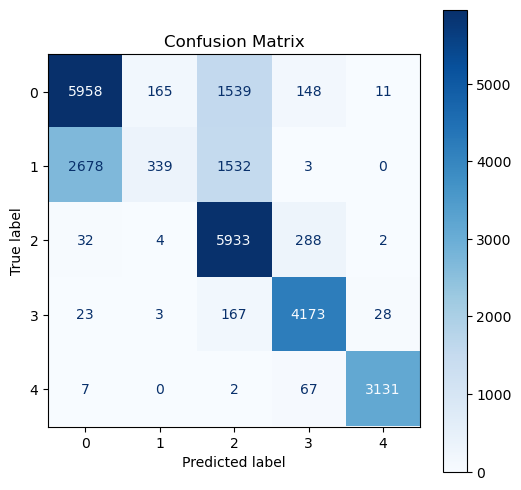

In [499]:
from sklearn.metrics import ConfusionMatrixDisplay

fig, ax = plt.subplots(figsize=(6,6))
ConfusionMatrixDisplay.from_estimator(xgboost_model_without, X_test_scaled, y_test, ax=ax, cmap='Blues')
plt.title('Confusion Matrix')
plt.show()

### Feature Selection: All Data

In [418]:
# SELECT Features to be trained
dataset = passengers_eu_df[['age','num_flights', 'luggage_size (kg)', 'layover_time', 'total_traveltime','amount_spent_cat']]
# Add categorical data
categorical = True
if categorical:
    dataset['sex_f'] = df_encoded['sex_f']
    dataset['sex_m'] = df_encoded['sex_m']
    dataset['business_trip_no'] = df_encoded['business_trip_no']
    dataset['business_trip_yes'] = df_encoded['business_trip_yes']
    dataset['traveled_with_family_no'] = df_encoded['traveled_with_family_no']
    dataset['traveled_with_family_yes'] = df_encoded['traveled_with_family_yes']
display(dataset.head())
print(dataset.dtypes)

C:\Users\User\AppData\Local\Temp\ipykernel_29180\2028058696.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset['sex_f'] = df_encoded['sex_f']
C:\Users\User\AppData\Local\Temp\ipykernel_29180\2028058696.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset['sex_m'] = df_encoded['sex_m']
C:\Users\User\AppData\Local\Temp\ipykernel_29180\2028058696.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value inst

,age,num_flights,luggage_size (kg),layover_time,total_traveltime,amount_spent_cat,sex_f,sex_m,business_trip_no,business_trip_yes,traveled_with_family_no,traveled_with_family_yes
0,42,1,19.0,0.00,550.48,2,False,True,False,True,True,False
1,48,2,19.0,62.48,1142.62,4,False,True,True,False,True,False
2,35,1,31.0,0.00,371.48,2,False,True,True,False,True,False
3,46,1,16.0,0.00,148.88,2,False,True,True,False,True,False
4,34,2,5.0,458.08,1655.78,3,False,True,False,True,True,False


age                           int64
num_flights                   int64
luggage_size (kg)           float64
layover_time                float64
total_traveltime            float64
amount_spent_cat              int64
sex_f                          bool
sex_m                          bool
business_trip_no               bool
business_trip_yes              bool
traveled_with_family_no        bool
traveled_with_family_yes       bool
dtype: object


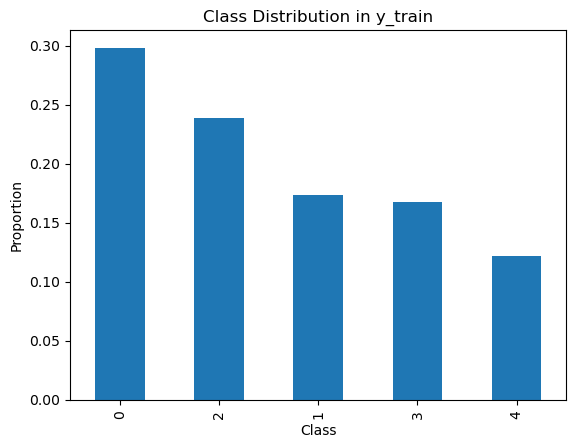

In [61]:
# Get normalized value counts
class_dist = y_train.value_counts(normalize=True)

# Plot as bar chart
class_dist.plot(kind='bar')

plt.title("Class Distribution in y_train")
plt.xlabel("Class")
plt.ylabel("Proportion")
plt.show()

## K-NN

In [455]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Features & target
X = dataset.drop(columns=['amount_spent_cat'])
y = dataset['amount_spent_cat']

# Train/test split 
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Data Standarization
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# KNN model
knn_model = KNeighborsClassifier(
    n_neighbors=5,  
    weights='distance',
    n_jobs=-1
)

# Train
knn_model.fit(X_train_scaled, y_train)

# Predict
y_pred = knn_model.predict(X_test_scaled)

# Evaluate
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))


Accuracy: 0.6795639080547402

Classification Report:
               precision    recall  f1-score   support

           0       0.71      0.71      0.71      7821
           1       0.56      0.57      0.56      4552
           2       0.61      0.61      0.61      6259
           3       0.75      0.80      0.77      4394
           4       0.83      0.74      0.79      3207

    accuracy                           0.68     26233
   macro avg       0.69      0.69      0.69     26233
weighted avg       0.68      0.68      0.68     26233


Confusion Matrix:
 [[5526  990 1174  128    3]
 [ 769 2596 1062  123    2]
 [1290  939 3814  141   75]
 [ 172  142  173 3504  403]
 [  12    4   28  776 2387]]


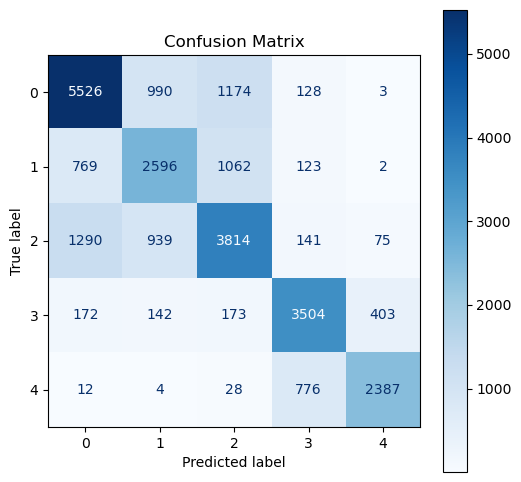

In [459]:
fig, ax = plt.subplots(figsize=(6,6))
ConfusionMatrixDisplay.from_estimator(knn_model, X_test_scaled, y_test, ax=ax, cmap='Blues')
plt.title('Confusion Matrix')
plt.show()

### XGBoost

In [422]:
# 1. Prepare features (X) and target (y)
X = dataset.drop(columns=['amount_spent_cat'])
y = dataset['amount_spent_cat']

# 2. Split dataset (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
print(y_train.value_counts())
print(y_test.value_counts())

# 3. Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 4. Train Logistic Regression
# Initialize XGBoost classifier
xgboost_model = xgb.XGBClassifier(
    objective='multi:softmax',  # for multi-class classification
    num_class=5,                # number of classes (0 to 4)
    learning_rate = 0.05,
    colsample_bytree = 1.0,
    max_depth = 7,
    n_estimators = 750,
    eval_metric='mlogloss',     # multi-class log loss
    use_label_encoder=False,
    random_state=42
)

# Train model
xgboost_model.fit(X_train, y_train)

# 5. Predict and evaluate
y_pred = xgboost_model.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

# Cross-validation (Stratified K-Fold)
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(xgboost_model, scaler.fit_transform(X), y, cv=skf, scoring='accuracy')

print("Cross-Validation Accuracy Scores:", cv_scores)
print("Mean CV Accuracy:", cv_scores.mean())

amount_spent_cat
0    31285
2    25038
1    18207
3    17576
4    12826
Name: count, dtype: int64
amount_spent_cat
0    7821
2    6259
1    4552
3    4394
4    3207
Name: count, dtype: int64


C:\Users\User\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [18:32:06] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Accuracy: 0.8077993367133001
Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.64      0.76      7821
           1       0.68      0.65      0.67      4552
           2       0.67      0.93      0.78      6259
           3       0.93      0.97      0.95      4394
           4       0.99      0.99      0.99      3207

    accuracy                           0.81     26233
   macro avg       0.84      0.83      0.83     26233
weighted avg       0.83      0.81      0.81     26233

Confusion Matrix:
 [[5012 1299 1398  107    5]
 [ 211 2978 1360    3    0]
 [ 155  114 5793  196    1]
 [  46    3   73 4242   30]
 [  18    0    1   22 3166]]


C:\Users\User\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [18:32:22] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
C:\Users\User\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [18:32:39] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
C:\Users\User\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [18:32:58] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
C:\Users\User\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [18:33:16] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain,

Cross-Validation Accuracy Scores: [0.80814242 0.8069607  0.80905729 0.81187817 0.80673198]
Mean CV Accuracy: 0.8085541112339418


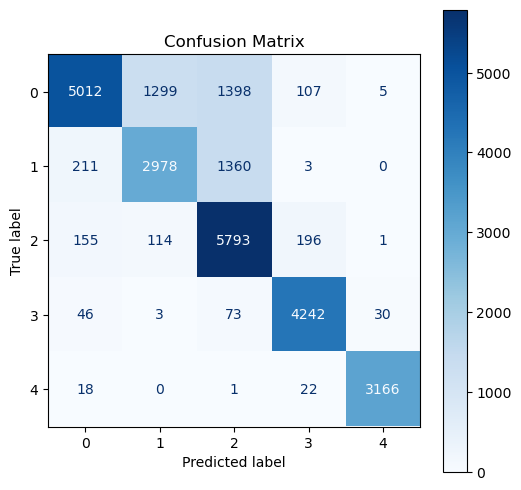

In [424]:
from sklearn.metrics import ConfusionMatrixDisplay

fig, ax = plt.subplots(figsize=(6,6))
ConfusionMatrixDisplay.from_estimator(xgboost_model, X_test, y_test, ax=ax, cmap='Blues')
plt.title('Confusion Matrix')
plt.show()

### Hypertuning for XGBoost Model

In [ ]:
from sklearn.model_selection import StratifiedKFold, GridSearchCV
import xgboost as xgb
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# 1. Features & target
X = dataset.drop(columns=['amount_spent_cat'])
y = dataset['amount_spent_cat']

# 2. Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# 3. Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 4. XGBoost model
xgb_model = xgb.XGBClassifier(
    objective='multi:softmax',
    num_class=len(y.unique()),
    eval_metric='mlogloss',
    use_label_encoder=False,
    random_state=42
)

# 5. Hyperparameter grid
param_grid = {
    'n_estimators': [300, 500, 750],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.7, 0.8, 1.0],
    'colsample_bytree': [0.7, 0.8, 1.0],
    'gamma': [0, 0.1, 0.3],
    'reg_alpha': [0, 0.1, 0.5],
    'reg_lambda': [1, 5, 10]
}

# 6. Stratified K-Fold
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# 7. Grid Search
grid_search = GridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid,
    scoring='accuracy',
    cv=cv=[(slice(None), slice(None))],
    verbose=2,
    n_jobs=-1
)

# 8. Train
grid_search.fit(X_train_scaled, y_train)

# 9. Best parameters & score
print("Best Parameters:", grid_search.best_params_)
print("Best CV Accuracy:", grid_search.best_score_)

# 10. Evaluate on test set
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test_scaled)

print("Test Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

Fitting 5 folds for each of 6561 candidates, totalling 32805 fits


### Neural Networks

In [434]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import numpy as np
from sklearn.preprocessing import normalize

In [ ]:
display(dataset)

In [441]:
dataset_normalized = pd.DataFrame(normalize(dataset, norm='max', axis=0), columns=dataset.columns)
display(dataset_normalized)

,age,num_flights,luggage_size (kg),layover_time,total_traveltime,amount_spent_cat,sex_f,sex_m,business_trip_no,business_trip_yes,traveled_with_family_no,traveled_with_family_yes
0,0.247059,0.5,0.612903,0.000000,0.245211,0.50,0.0,1.0,0.0,1.0,1.0,0.0
1,0.282353,1.0,0.612903,0.070519,0.508980,1.00,0.0,1.0,1.0,0.0,1.0,0.0
2,0.205882,0.5,1.000000,0.000000,0.165476,0.50,0.0,1.0,1.0,0.0,1.0,0.0
3,0.270588,0.5,0.516129,0.000000,0.066319,0.50,0.0,1.0,1.0,0.0,1.0,0.0
4,0.200000,1.0,0.161290,0.517020,0.737567,0.75,0.0,1.0,0.0,1.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
131160,0.170588,0.5,0.677419,0.000000,0.445851,0.00,1.0,0.0,1.0,0.0,0.0,1.0
131161,0.211765,1.0,0.967742,0.154718,0.212747,0.50,1.0,0.0,0.0,1.0,1.0,0.0
131162,0.282353,1.0,0.290323,0.084853,0.332471,0.25,1.0,0.0,1.0,0.0,1.0,0.0
131163,0.152941,0.5,0.290323,0.000000,0.058390,0.00,1.0,0.0,0.0,1.0,1.0,0.0


In [443]:
X = dataset_normalized[['age','num_flights', 'luggage_size (kg)', 'layover_time', 'total_traveltime', 'sex_f', 'sex_m', 
                       'business_trip_no', 'business_trip_yes', 'traveled_with_family_no', 'traveled_with_family_yes']]
y = dataset[['amount_spent_cat']]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

# Conver the Numpy arrays to PyTorch Tensors
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32, requires_grad=False)
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32, requires_grad=False)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32, requires_grad=False)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32, requires_grad=False)

y_train_tensor = y_train_tensor.squeeze().long()
y_test_tensor = y_test_tensor.squeeze().long()

print(f'X train shape is {X_train_tensor.shape}')
print(f'X test shape is {X_test_tensor.shape}')
print(f'y train shape is {y_train_tensor.shape}')
print(f'y test shape is {y_test_tensor.shape}')
print(y_train_tensor.dtype)
print(y_train_tensor)

X train shape is torch.Size([104932, 11])
X test shape is torch.Size([26233, 11])
y train shape is torch.Size([104932])
y test shape is torch.Size([26233])
torch.int64
tensor([4, 0, 0,  ..., 2, 0, 4])


In [445]:
class SimpleNN(torch.nn.Module):
    def __init__(self, input_width: int, hidden_width: int, output_width: int):
        if not all(isinstance(param, int) for param in [input_width, hidden_width, output_width]):
            raise TypeError("All input parameters must be integers")
        else:
            super(SimpleNN, self).__init__()

        self.fc1 = torch.nn.Linear(input_width, hidden_width)
        self.fc2 = torch.nn.Linear(hidden_width, hidden_width)
        self.fc3 = torch.nn.Linear(hidden_width, hidden_width)
        self.fc4 = torch.nn.Linear(hidden_width, hidden_width)
        self.fc5 = torch.nn.Linear(hidden_width, output_width)

        # Activation functions
        self.relu = torch.nn.ReLU()
        self.tanh = torch.nn.Tanh()
        self.softmax = torch.nn.Softmax(dim=1)  # For classification output
    def forward(self, input_data: torch.Tensor) -> torch.Tensor:
        ''' Forward pass of the SimpleNN

            Args:
                input_data: Input data tensor (features of data)

            Returns:
                forward_data: Output probability tensor after forward pass
        '''
        forward_data = self.fc1(input_data)
        forward_data = self.tanh(forward_data)

        forward_data = self.fc2(forward_data)
        forward_data = self.tanh(forward_data)

        forward_data = self.fc3(forward_data)
        forward_data = self.tanh(forward_data)

        forward_data = self.fc4(forward_data)
        forward_data = self.tanh(forward_data)

        forward_data = self.fc5(forward_data)

        return forward_data

input_width = 11
hidden_width = 16
output_width = 5
learning_rate = 0.001
num_epochs = 3000

nn_model = SimpleNN(input_width, hidden_width, output_width)

optimizer = optim.Adam(params=nn_model.parameters(), lr=learning_rate)

loss_function = torch.nn.CrossEntropyLoss()

In [447]:
for epoch in range(num_epochs):
    # Forward pass
    output_Y2 = nn_model(X_train_tensor)

    loss = loss_function(output_Y2, y_train_tensor)

    # Backward pass
    optimizer.zero_grad()

    loss.backward()

    # Optimization: update weights and biases
    optimizer.step()

    # Print the loss every 100 epochs
    if (epoch + 1) % 100 == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}')

# Optional: check accuracy every 500 epochs
    if (epoch + 1) % 500 == 0:
        nn_model.eval()
        with torch.no_grad():
            test_outputs = nn_model(X_test_tensor)
            _, predicted = torch.max(test_outputs, 1)
            correct = (predicted == y_test_tensor).sum().item()
            accuracy = correct / y_test_tensor.size(0)
            print(f'Accuracy at epoch {epoch + 1}: {accuracy:.4f}')
        nn_model.train()

Epoch [100/3000], Loss: 1.2879
Epoch [200/3000], Loss: 0.8780
Epoch [300/3000], Loss: 0.7993
Epoch [400/3000], Loss: 0.7560
Epoch [500/3000], Loss: 0.7297
Accuracy at epoch 500: 0.7114
Epoch [600/3000], Loss: 0.7138
Epoch [700/3000], Loss: 0.7016
Epoch [800/3000], Loss: 0.6911
Epoch [900/3000], Loss: 0.6815
Epoch [1000/3000], Loss: 0.6724
Accuracy at epoch 1000: 0.7231
Epoch [1100/3000], Loss: 0.6634
Epoch [1200/3000], Loss: 0.6542
Epoch [1300/3000], Loss: 0.6450
Epoch [1400/3000], Loss: 0.6361
Epoch [1500/3000], Loss: 0.6282
Accuracy at epoch 1500: 0.7311
Epoch [1600/3000], Loss: 0.6219
Epoch [1700/3000], Loss: 0.6167
Epoch [1800/3000], Loss: 0.6122
Epoch [1900/3000], Loss: 0.6088
Epoch [2000/3000], Loss: 0.6060
Accuracy at epoch 2000: 0.7391
Epoch [2100/3000], Loss: 0.6037
Epoch [2200/3000], Loss: 0.6016
Epoch [2300/3000], Loss: 0.5998
Epoch [2400/3000], Loss: 0.5983
Epoch [2500/3000], Loss: 0.5969
Accuracy at epoch 2500: 0.7407
Epoch [2600/3000], Loss: 0.5956
Epoch [2700/3000], Loss

In [ ]:
display(predicted)

# WW Passengers Dataset

In [461]:
display(passengers_ww_df.head())
print(passengers_ww_df.shape)

,name,sex,birth_date,shopped_at,business_trip,traveled_with_family,luggage,total_flighttime,total_traveltime,layover_time,flight_number_1,departure_IATA_1,destination_IATA_1,flight_number_2,departure_IATA_2,destination_IATA_2
0,Gabriela Schmidlin,f,24/06/1984,HND,yes,no,Brief Case (4L),744.43,744.43,0.0,6U 2572,HND,ADD,NaN,NaN,NaN
1,Kaixin Banacloche,f,31/05/1992,KUL,yes,no,Duffel Bag 12KG,732.68,732.68,0.0,AF 1390,KUL,AMS,NaN,NaN,NaN
2,Manuela Thalberg,f,11/05/1964,HND,yes,no,Duffel Bag 7lbs,523.70,523.70,0.0,SQ 1981,BNE,HND,NaN,NaN,NaN
3,Klaudia Osterhagen,f,17/09/1994,SFO,no,yes,Duffel Bag 16L,876.85,876.85,0.0,IBE 4556,DEL,SFO,NaN,NaN,NaN
4,Cris Caci,f,20/06/1990,JFK,yes,no,Cosmetic Case (3lbs),1077.70,1634.20,556.5,EK 0016,CPT,JFK,QR 8307,JFK,HAV


(73140, 16)


### Data Consistency Check

In [463]:
# Check if there are any missing values
check_missing_values(passengers_ww_df)

passengers_ww_df = passengers_ww_df.apply(fill_from_lookup, axis=1)
check_missing_values(passengers_ww_df)

passengers_ww_df = passengers_ww_df.apply(fill_from_lookup_flight2, axis=1)
check_missing_values(passengers_ww_df)

# Drop missing values
drop_flight_1_missing_values(passengers_ww_df)
drop_flight_2_missing_values(passengers_ww_df)

# Check again
check_missing_values(passengers_ww_df)
print(passengers_ww_df.shape)

# Delete any duplicated rows from the dataset
print(f"Number of duplicated rows:{passengers_ww_df.duplicated().sum()}")
passengers_ww_df.drop_duplicates(inplace=True)

name                        0
sex                         0
birth_date                  0
shopped_at                  0
business_trip               0
traveled_with_family        0
luggage                     0
total_flighttime            0
total_traveltime            0
layover_time                0
flight_number_1             0
departure_IATA_1            0
destination_IATA_1          0
flight_number_2         52240
departure_IATA_2        52240
destination_IATA_2      52240
dtype: int64
Percentage missing departure_IATA_1: 0.00%
Percentage missing destination_IATA_1: 0.00%

Invalid missing values for connecting flights only:
  flight_number_2: 0 rows (0.00%)
  departure_IATA_2: 0 rows (0.00%)
  destination_IATA_2: 0 rows (0.00%)
name                        0
sex                         0
birth_date                  0
shopped_at                  0
business_trip               0
traveled_with_family        0
luggage                     0
total_flighttime            0
total_traveltime    

In [152]:
# Check the dataset's shape
print(passengers_ww_df.shape)

(67766, 16)


In [465]:
# Parsing the luggage column
passengers_ww_df[['luggage_type', 'luggage_size', 'luggage_size_unit']] = passengers_ww_df['luggage'].apply(parse_luggage)
# Drop the original column
passengers_ww_df.drop('luggage', axis=1, inplace=True)
display(passengers_ww_df.head())

,name,sex,birth_date,shopped_at,business_trip,traveled_with_family,total_flighttime,total_traveltime,layover_time,flight_number_1,departure_IATA_1,destination_IATA_1,flight_number_2,departure_IATA_2,destination_IATA_2,luggage_type,luggage_size,luggage_size_unit
0,Gabriela Schmidlin,f,24/06/1984,HND,yes,no,744.43,744.43,0.0,6U 2572,HND,ADD,NaN,NaN,NaN,Brief Case,4,l
1,Kaixin Banacloche,f,31/05/1992,KUL,yes,no,732.68,732.68,0.0,AF 1390,KUL,AMS,NaN,NaN,NaN,Duffel Bag,12,kg
2,Manuela Thalberg,f,11/05/1964,HND,yes,no,523.70,523.70,0.0,SQ 1981,BNE,HND,NaN,NaN,NaN,Duffel Bag,7,lbs
3,Klaudia Osterhagen,f,17/09/1994,SFO,no,yes,876.85,876.85,0.0,IBE 4556,DEL,SFO,NaN,NaN,NaN,Duffel Bag,16,l
4,Cris Caci,f,20/06/1990,JFK,yes,no,1077.70,1634.20,556.5,EK 0016,CPT,JFK,QR 8307,JFK,HAV,Cosmetic Case,3,lbs


In [467]:
# Convert luggage_size to Kilograms
passengers_ww_df['luggage_size (kg)'] = passengers_ww_df.apply(convert_2_kg, axis=1)
passengers_ww_df['luggage_size (kg)'] = passengers_ww_df['luggage_size (kg)'].round(1)

# Delete original columns
passengers_ww_df.drop(columns=['luggage_size', 'luggage_size_unit'], inplace=True)

display(passengers_ww_df.head())

,name,sex,birth_date,shopped_at,business_trip,traveled_with_family,total_flighttime,total_traveltime,layover_time,flight_number_1,departure_IATA_1,destination_IATA_1,flight_number_2,departure_IATA_2,destination_IATA_2,luggage_type,luggage_size (kg)
0,Gabriela Schmidlin,f,24/06/1984,HND,yes,no,744.43,744.43,0.0,6U 2572,HND,ADD,NaN,NaN,NaN,Brief Case,4.0
1,Kaixin Banacloche,f,31/05/1992,KUL,yes,no,732.68,732.68,0.0,AF 1390,KUL,AMS,NaN,NaN,NaN,Duffel Bag,12.0
2,Manuela Thalberg,f,11/05/1964,HND,yes,no,523.70,523.70,0.0,SQ 1981,BNE,HND,NaN,NaN,NaN,Duffel Bag,3.2
3,Klaudia Osterhagen,f,17/09/1994,SFO,no,yes,876.85,876.85,0.0,IBE 4556,DEL,SFO,NaN,NaN,NaN,Duffel Bag,16.0
4,Cris Caci,f,20/06/1990,JFK,yes,no,1077.70,1634.20,556.5,EK 0016,CPT,JFK,QR 8307,JFK,HAV,Cosmetic Case,1.4


In [469]:
# Convert birth_date to datetime
passengers_ww_df['birth_date'] = pd.to_datetime(passengers_ww_df['birth_date'], format='mixed')

# Since data was collected on 31.12.2019, it will be used as ref to extract the age
ref_date = datetime(2019, 12, 31)
passengers_ww_df['age'] = passengers_ww_df['birth_date'].apply(
    lambda birth_date: (ref_date - birth_date).days // 365
)
display(passengers_ww_df.head())
print(passengers_ww_df.shape)

,name,sex,birth_date,shopped_at,business_trip,traveled_with_family,total_flighttime,total_traveltime,layover_time,flight_number_1,departure_IATA_1,destination_IATA_1,flight_number_2,departure_IATA_2,destination_IATA_2,luggage_type,luggage_size (kg),age
0,Gabriela Schmidlin,f,1984-06-24,HND,yes,no,744.43,744.43,0.0,6U 2572,HND,ADD,NaN,NaN,NaN,Brief Case,4.0,35
1,Kaixin Banacloche,f,1992-05-31,KUL,yes,no,732.68,732.68,0.0,AF 1390,KUL,AMS,NaN,NaN,NaN,Duffel Bag,12.0,27
2,Manuela Thalberg,f,1964-11-05,HND,yes,no,523.70,523.70,0.0,SQ 1981,BNE,HND,NaN,NaN,NaN,Duffel Bag,3.2,55
3,Klaudia Osterhagen,f,1994-09-17,SFO,no,yes,876.85,876.85,0.0,IBE 4556,DEL,SFO,NaN,NaN,NaN,Duffel Bag,16.0,25
4,Cris Caci,f,1990-06-20,JFK,yes,no,1077.70,1634.20,556.5,EK 0016,CPT,JFK,QR 8307,JFK,HAV,Cosmetic Case,1.4,29


(67766, 18)


,name,birth_date,shopped_at,total_flighttime,total_traveltime,layover_time,amount_spent_cat,flight_number_1,departure_IATA_1,destination_IATA_1,...,luggage_size (kg),distance (km),age,num_flights,sex_f,sex_m,business_trip_no,business_trip_yes,traveled_with_family_no,traveled_with_family_yes
0,Christian Kluge,1977-02-28,BCN,550.48,550.48,0.00,2,LH 5507,BCN,KTM,...,19.0,7493.0,42,1,False,True,False,True,True,False
1,Bernd Jung,1971-05-10,MUC,1080.14,1142.62,62.48,4,AXM 2562,HGA,MUC,...,19.0,14573.0,48,2,False,True,True,False,True,False
2,Ralph Dewhirst,1984-10-04,HEL,371.48,371.48,0.00,2,WY 9256,HEL,MCT,...,31.0,4823.0,35,1,False,True,True,False,True,False
3,Jan Egger,1973-01-21,VIE,148.88,148.88,0.00,2,MH 8130,VIE,LPL,...,16.0,1479.0,46,1,False,True,True,False,True,False
4,Tom Probst,1985-03-31,FRA,1197.70,1655.78,458.08,3,CA 6749,ZNZ,FRA,...,5.0,15277.0,34,2,False,True,False,True,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
132229,Martin Cluckey,1990-05-15,CDG,1000.90,1000.90,0.00,0,EY 1046,PER,CDG,...,21.0,14273.0,29,1,True,False,True,False,False,True
132230,Florina ramona Bande,1983-09-23,MUC,340.52,477.60,137.08,2,KLM 7275,MSQ,MUC,...,30.0,3602.0,36,2,True,False,False,True,True,False
132231,Samara Zonia,1971-10-08,FCO,671.19,746.37,75.18,1,AY 7165,CMB,FCO,...,9.0,7671.0,48,2,True,False,True,False,True,False
132232,Kizkitza Archidona,1993-03-22,MUC,131.08,131.08,0.00,0,LH 8939,MUC,PMI,...,9.0,1216.0,26,1,True,False,False,True,True,False


,total_flighttime,total_traveltime,layover_time,amount_spent_cat,luggage_size (kg),distance (km),age,num_flights,sex_f,sex_m,business_trip_no,business_trip_yes,traveled_with_family_no,traveled_with_family_yes
0,550.48,550.48,0.00,2,19.0,7493.0,42,1,False,True,False,True,True,False
1,1080.14,1142.62,62.48,4,19.0,14573.0,48,2,False,True,True,False,True,False
2,371.48,371.48,0.00,2,31.0,4823.0,35,1,False,True,True,False,True,False
3,148.88,148.88,0.00,2,16.0,1479.0,46,1,False,True,True,False,True,False
4,1197.70,1655.78,458.08,3,5.0,15277.0,34,2,False,True,False,True,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
132229,1000.90,1000.90,0.00,0,21.0,14273.0,29,1,True,False,True,False,False,True
132230,340.52,477.60,137.08,2,30.0,3602.0,36,2,True,False,False,True,True,False
132231,671.19,746.37,75.18,1,9.0,7671.0,48,2,True,False,True,False,True,False
132232,131.08,131.08,0.00,0,9.0,1216.0,26,1,True,False,False,True,True,False


******************Correlation Matrix*****************


,total_flighttime,total_traveltime,layover_time,luggage_size (kg),age,sex_f,sex_m,business_trip_no,business_trip_yes,traveled_with_family_no,traveled_with_family_yes
total_flighttime,1.000000,0.921172,0.515338,-0.000472,0.003207,-0.000011,0.000011,-0.001923,0.001923,0.000876,-0.000876
total_traveltime,0.921172,1.000000,0.808217,0.000697,0.001797,0.002628,-0.002628,-0.004684,0.004684,0.001363,-0.001363
layover_time,0.515338,0.808217,1.000000,0.002250,-0.000896,0.005805,-0.005805,-0.007404,0.007404,0.001677,-0.001677
luggage_size (kg),-0.000472,0.000697,0.002250,1.000000,0.000720,-0.004568,0.004568,0.001209,-0.001209,-0.001266,0.001266
age,0.003207,0.001797,-0.000896,0.000720,1.000000,-0.005735,0.005735,-0.041035,0.041035,0.015711,-0.015711
sex_f,-0.000011,0.002628,0.005805,-0.004568,-0.005735,1.000000,-1.000000,-0.000924,0.000924,-0.000625,0.000625
sex_m,0.000011,-0.002628,-0.005805,0.004568,0.005735,-1.000000,1.000000,0.000924,-0.000924,0.000625,-0.000625
business_trip_no,-0.001923,-0.004684,-0.007404,0.001209,-0.041035,-0.000924,0.000924,1.000000,-1.000000,-0.366676,0.366676
business_trip_yes,0.001923,0.004684,0.007404,-0.001209,0.041035,0.000924,-0.000924,-1.000000,1.000000,0.366676,-0.366676
traveled_with_family_no,0.000876,0.001363,0.001677,-0.001266,0.015711,-0.000625,0.000625,-0.366676,0.366676,1.000000,-1.000000


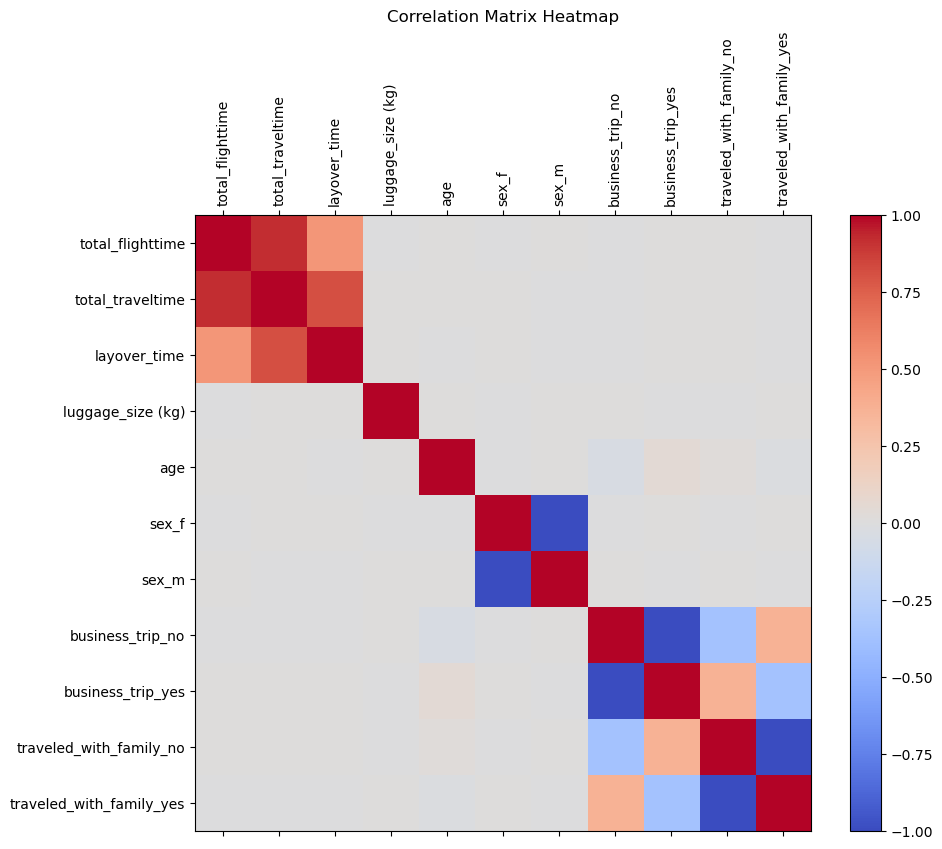

In [471]:
# One Hot Encoding for categorical data
categorical_cols = ['sex', 'business_trip', 'traveled_with_family']
ww_df_encoded = pd.get_dummies(passengers_ww_df, columns=categorical_cols, drop_first=False)
display(df_encoded)

# Display the correlation matrix for the numeric values
ww_numeric_df = ww_df_encoded.select_dtypes(include=[np.number, 'bool'])
display(numeric_df)

#numeric_df = passengers_eu_df.select_dtypes(include=['number','float64'])
corr = ww_numeric_df.corr()
print('******************Correlation Matrix*****************')
display(corr)


fig, ax = plt.subplots(figsize=(10, 8))
cax = ax.matshow(corr, cmap='coolwarm')

# Add colorbar
fig.colorbar(cax)

# Set ticks and labels
ticks = np.arange(len(corr.columns))
ax.set_xticks(ticks)
ax.set_yticks(ticks)
ax.set_xticklabels(corr.columns, rotation=90)
ax.set_yticklabels(corr.columns)

plt.title('Correlation Matrix Heatmap')
plt.show()

In [ ]:
print(passengers_ww_df.dtypes)
print(passengers_ww_df.shape)

In [473]:
# New Column: num_flights
# If flight_number_2 is empty or NaN, num_flights = 1, else 2
passengers_ww_df['num_flights'] = passengers_ww_df['flight_number_2'].apply(lambda x: 1 if pd.isna(x) or x == '' else 2)

# Check the new feature
display(passengers_ww_df.head())

,name,sex,birth_date,shopped_at,business_trip,traveled_with_family,total_flighttime,total_traveltime,layover_time,flight_number_1,departure_IATA_1,destination_IATA_1,flight_number_2,departure_IATA_2,destination_IATA_2,luggage_type,luggage_size (kg),age,num_flights
0,Gabriela Schmidlin,f,1984-06-24,HND,yes,no,744.43,744.43,0.0,6U 2572,HND,ADD,NaN,NaN,NaN,Brief Case,4.0,35,1
1,Kaixin Banacloche,f,1992-05-31,KUL,yes,no,732.68,732.68,0.0,AF 1390,KUL,AMS,NaN,NaN,NaN,Duffel Bag,12.0,27,1
2,Manuela Thalberg,f,1964-11-05,HND,yes,no,523.70,523.70,0.0,SQ 1981,BNE,HND,NaN,NaN,NaN,Duffel Bag,3.2,55,1
3,Klaudia Osterhagen,f,1994-09-17,SFO,no,yes,876.85,876.85,0.0,IBE 4556,DEL,SFO,NaN,NaN,NaN,Duffel Bag,16.0,25,1
4,Cris Caci,f,1990-06-20,JFK,yes,no,1077.70,1634.20,556.5,EK 0016,CPT,JFK,QR 8307,JFK,HAV,Cosmetic Case,1.4,29,2


## Model Training

In [475]:
# SELECT Data to be trained
ww_dataset = passengers_ww_df[['age','num_flights', 'luggage_size (kg)', 'layover_time', 'total_traveltime']]

# Add categorical data
categorical = True
if categorical:
    ww_dataset['sex_f'] = ww_df_encoded['sex_f']
    ww_dataset['sex_m'] = ww_df_encoded['sex_m']
    ww_dataset['business_trip_no'] = ww_df_encoded['business_trip_no']
    ww_dataset['business_trip_yes'] = ww_df_encoded['business_trip_yes']
    ww_dataset['traveled_with_family_no'] = ww_df_encoded['traveled_with_family_no']
    ww_dataset['traveled_with_family_yes'] = ww_df_encoded['traveled_with_family_yes']
display(ww_dataset.head())
print(ww_dataset.dtypes)

C:\Users\User\AppData\Local\Temp\ipykernel_29180\3081791902.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ww_dataset['sex_f'] = ww_df_encoded['sex_f']
C:\Users\User\AppData\Local\Temp\ipykernel_29180\3081791902.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ww_dataset['sex_m'] = ww_df_encoded['sex_m']
C:\Users\User\AppData\Local\Temp\ipykernel_29180\3081791902.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] 

,age,num_flights,luggage_size (kg),layover_time,total_traveltime,sex_f,sex_m,business_trip_no,business_trip_yes,traveled_with_family_no,traveled_with_family_yes
0,35,1,4.0,0.0,744.43,True,False,False,True,True,False
1,27,1,12.0,0.0,732.68,True,False,False,True,True,False
2,55,1,3.2,0.0,523.70,True,False,False,True,True,False
3,25,1,16.0,0.0,876.85,True,False,True,False,False,True
4,29,2,1.4,556.5,1634.20,True,False,False,True,True,False


age                           int64
num_flights                   int64
luggage_size (kg)           float64
layover_time                float64
total_traveltime            float64
sex_f                          bool
sex_m                          bool
business_trip_no               bool
business_trip_yes              bool
traveled_with_family_no        bool
traveled_with_family_yes       bool
dtype: object


In [477]:
# Predict class labels directly
y_pred_classes = xgboost_model.predict(ww_dataset)
ww_dataset['predicted_amount_spent_cat'] = y_pred_classes

C:\Users\User\AppData\Local\Temp\ipykernel_29180\2570430276.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ww_dataset['predicted_amount_spent_cat'] = y_pred_classes


In [479]:
display(ww_dataset.head())

,age,num_flights,luggage_size (kg),layover_time,total_traveltime,sex_f,sex_m,business_trip_no,business_trip_yes,traveled_with_family_no,traveled_with_family_yes,predicted_amount_spent_cat
0,35,1,4.0,0.0,744.43,True,False,False,True,True,False,0
1,27,1,12.0,0.0,732.68,True,False,False,True,True,False,0
2,55,1,3.2,0.0,523.70,True,False,False,True,True,False,2
3,25,1,16.0,0.0,876.85,True,False,True,False,False,True,0
4,29,2,1.4,556.5,1634.20,True,False,False,True,True,False,3


In [481]:
## Adding the shopped_at column
ww_dataset['shopped_at'] = passengers_ww_df['shopped_at']
display(ww_dataset.head())

# Count how many passengers fall into each category per airport
category_counts = ww_dataset.groupby(['shopped_at', 'predicted_amount_spent_cat']).size().unstack(fill_value=0)

display(category_counts)

C:\Users\User\AppData\Local\Temp\ipykernel_29180\1748887636.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ww_dataset['shopped_at'] = passengers_ww_df['shopped_at']


,age,num_flights,luggage_size (kg),layover_time,total_traveltime,sex_f,sex_m,business_trip_no,business_trip_yes,traveled_with_family_no,traveled_with_family_yes,predicted_amount_spent_cat,shopped_at
0,35,1,4.0,0.0,744.43,True,False,False,True,True,False,0,HND
1,27,1,12.0,0.0,732.68,True,False,False,True,True,False,0,KUL
2,55,1,3.2,0.0,523.70,True,False,False,True,True,False,2,HND
3,25,1,16.0,0.0,876.85,True,False,True,False,False,True,0,SFO
4,29,2,1.4,556.5,1634.20,True,False,False,True,True,False,3,JFK


predicted_amount_spent_cat,0,1,2,3,4
shopped_at,,,,,
DFW,1175,844,1551,1488,883
DXB,1290,871,1550,1384,868
EZE,1448,836,1649,1166,483
HKG,1177,734,1469,1496,850
HND,1213,830,1617,1397,857
JFK,1362,954,1764,1361,856
KUL,1075,696,1369,1490,816
MEL,839,262,912,1961,797
PEK,1191,850,1564,1260,809


In [487]:
# Airports
category_to_avg_amount = {
    0: 5,     # midpoint of 0 to 10 EUR
    1: 30,    # midpoint of 10 to 50 EUR
    2: 100,   # midpoint of 50 to 150 EUR
    3: 225,   # midpoint of 150 to 300 EUR
    4: 400    # midpoint of 300 to 500 EUR
}

ww_dataset['predicted_amount'] = ww_dataset['predicted_amount_spent_cat'].map(category_to_avg_amount)

expenditure_per_airport = ww_dataset.groupby('shopped_at')['predicted_amount'].sum().sort_values(ascending=False)

# Convert to a dataframe
df_expenditure = expenditure_per_airport.reset_index()
df_expenditure.columns = ['airport', 'yearly_revenue']  # only 2 columns here
display(df_expenditure)

C:\Users\User\AppData\Local\Temp\ipykernel_29180\3213503132.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ww_dataset['predicted_amount'] = ww_dataset['predicted_amount_spent_cat'].map(category_to_avg_amount)


,airport,yearly_revenue
0,DFW,874295
1,MEL,863280
2,JFK,860455
3,HKG,851405
4,HND,849790
5,DXB,846180
6,SFO,831690
7,KUL,824805
8,PVG,817100
9,SIN,799690


# Results

In [ ]:
# Print the total number of customers for each catgeory (for the highest 3 airports)

In [485]:
# Map sqm and price from airports_terms_of_lease_df to df_expenditure by airport code
df_expenditure['sqm_of_store'] = df_expenditure['airport'].map(
    airports_terms_of_lease_df.set_index('airport')['sqm_of_store']
)
df_expenditure['price_per_sqm_month'] = df_expenditure['airport'].map(
    airports_terms_of_lease_df.set_index('airport')['price_per_sqm_month']
)

# Calculate profit per year for each airport
df_expenditure['yearly_lease_cost'] = df_expenditure['sqm_of_store'] * df_expenditure['price_per_sqm_month'] * 12
df_expenditure['yearly_profit'] = df_expenditure['yearly_revenue'] - df_expenditure['yearly_lease_cost']
display(df_expenditure)

,airport,yearly_revenue,sqm_of_store,price_per_sqm_month,yearly_lease_cost,yearly_profit
0,DFW,874295,42,21,10584,863711
1,MEL,863280,207,27,67068,796212
2,JFK,860455,97,27,31428,829027
3,HKG,851405,150,28,50400,801005
4,HND,849790,117,23,32292,817498
5,DXB,846180,151,23,41676,804504
6,SFO,831690,181,28,60816,770874
7,KUL,824805,119,19,27132,797673
8,PVG,817100,59,19,13452,803648
9,SIN,799690,41,27,13284,786406


## Results Visualization

C:\Users\User\AppData\Local\Temp\ipykernel_29180\1048821080.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='airport', y='yearly_revenue', data=df_expenditure, palette='Blues_d')


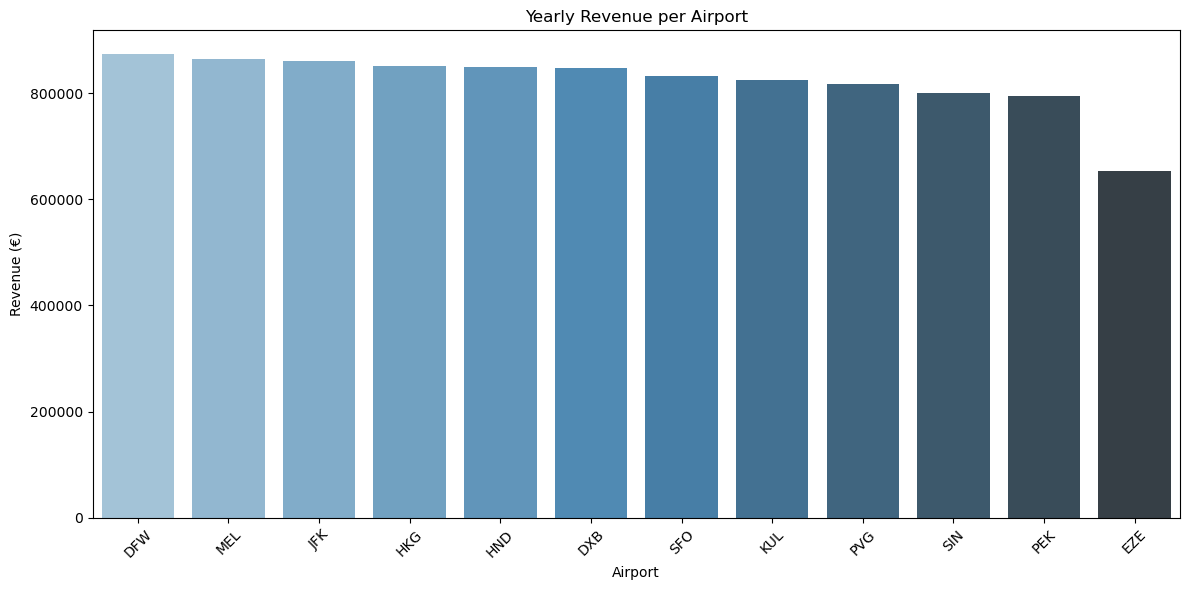

In [491]:
# Bar Plot: Daily Revenue per Airport
plt.figure(figsize=(12,6))
sns.barplot(x='airport', y='yearly_revenue', data=df_expenditure, palette='Blues_d')
plt.title('Yearly Revenue per Airport')
plt.ylabel('Revenue (€)')
plt.xlabel('Airport')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

C:\Users\User\AppData\Local\Temp\ipykernel_26232\2906283220.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='airport', y='yearly_profit', data=df_expenditure, palette='Greens_d')


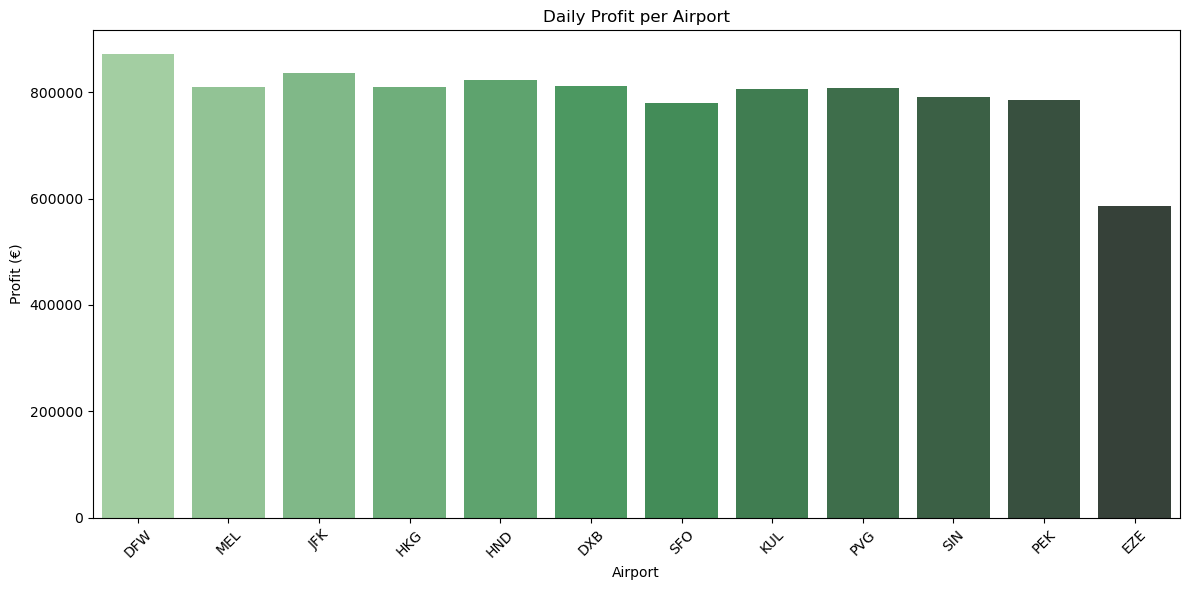

In [194]:
# Profit per Airport
plt.figure(figsize=(12,6))
sns.barplot(x='airport', y='yearly_profit', data=df_expenditure, palette='Greens_d')
plt.title('Daily Profit per Airport')
plt.ylabel('Profit (€)')
plt.xlabel('Airport')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

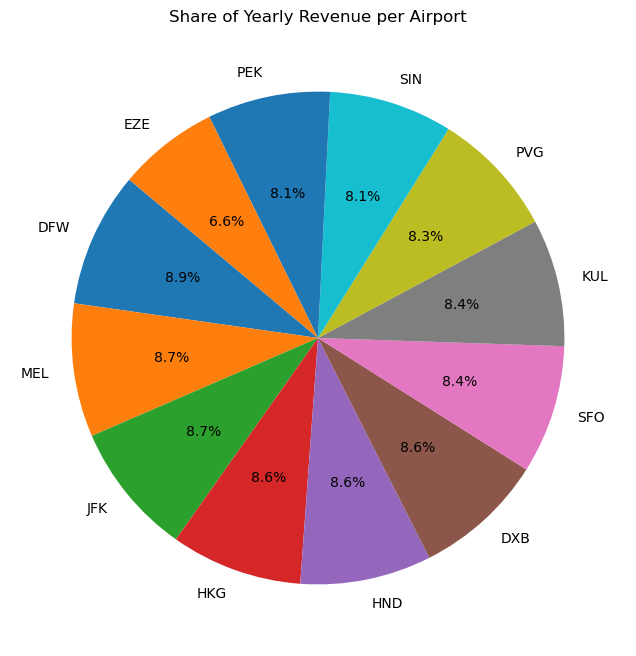

In [493]:
# Pie Chart: Share of Total Revenue
plt.figure(figsize=(8,8))
plt.pie(df_expenditure['yearly_revenue'], labels=df_expenditure['airport'], autopct='%1.1f%%', startangle=140)
plt.title('Share of Yearly Revenue per Airport')
plt.show()